In [24]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.utils import resample # équilibrage de classes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Préparation des données pour entrainement
from sklearn.model_selection import train_test_split

# Paramètres du modèle
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report


# sauvegarde des hyperparamètres
import pickle

# Explicabilité
import shap

# Fonctions utiles 

In [70]:
def display_basic_info(df):
    """Affiche les informations de base sur le DataFrame, y compris sa forme, ses colonnes,
    un résumé descriptif, les valeurs manquantes par colonne et les premières lignes."""
    
    print("Shape of the DataFrame:", df.shape)
    print('\nNumbre of unique patients :', df['Patient_ID'].nunique())
    if 'SepsisLabel' in df.columns:
        print("\nLignes classes counts : ", df['SepsisLabel'].value_counts())
    if 'will_have_sepsis' in df.columns:
        print('\nClasses counts : ', df['will_have_sepsis'].value_counts())
    print("\nColumns in the DataFrame:", df.columns)
    print("\nData Types:\n", df.dtypes)
    display("Descriptive Statistics:", df.describe())
    print("\nMissing Values Per Column:\n", df.isna().sum())
    display("First 5 Rows of the DataFrame:", df.head())


def objective(trial, X, y, cv=7):
    """
    Fonction objectif pour l'optimisation d'hyperparamètres avec Optuna.

    Args:
    trial (optuna.trial): Un essai de Optuna pour suggérer les hyperparamètres.
    X (DataFrame): Features du dataset.
    y (Series): Étiquettes cibles du dataset.
    cv (int): Nombre de plis pour la validation croisée.

    Returns:
    float: La moyenne des scores de validation croisée pour les hyperparamètres suggérés.
    """
    # Hyperparamètres suggérés par Optuna
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
    max_depth = trial.suggest_int('max_depth', 2, 15)
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_uniform('gamma', 0.01, 5)
    subsample = trial.suggest_uniform('subsample', 0.01, 1)
    
    # Création et évaluation du modèle
    clf = XGBClassifier(learning_rate=learning_rate,
                        max_depth=max_depth,
                        n_estimators=n_estimators,
                        min_child_weight=min_child_weight,
                        gamma=gamma,
                        subsample=subsample,
                        use_label_encoder=False,
                        eval_metric='logloss')
    
    # Calcul du score moyen sur les plis de validation croisée
    score = cross_val_score(clf, X, y, cv=cv)
    
    return np.mean(score)

def create_xgb_classifier(params):
    """Crée un classificateur XGBoost configuré avec un dictionnaire de paramètres."""
    return XGBClassifier(
        n_jobs=-1,
        tree_method='hist',
        subsample=params.get('subsample', 0.8),
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        min_child_weight=params['min_child_weight'],
        gamma=params['gamma'],
        use_label_encoder=False,
        eval_metric='logloss'
    )

def objective_v2(trial, X, y, cv=7):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'n_estimators': trial.suggest_int('n_estimators', 50, 250),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 5),
        'subsample': trial.suggest_float('subsample', 0.01, 1)
    }
    clf = create_xgb_classifier(params)
    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    return np.mean(score)

def train_and_save_xgboost_classifier_v2(X_train, y_train, best_params, model_path):
    xgbc = create_xgb_classifier(best_params)
    xgbc.fit(X_train, y_train,
             eval_set=[(X_test, y_test)], 
            early_stopping_rounds=20,  # Arrête si auc ne s'améliore pas après 10 itérations
            verbose=True)
    
    with open(model_path, 'wb') as file:
        pickle.dump(xgbc, file)
    return xgbc


def perform_hyperparameter_optimization(X, y, objective, n_trials=50, random_state=42):
    """
    Crée une étude Optuna pour optimiser les hyperparamètres d'un modèle de machine learning.

    Args:
    X (DataFrame): Les features d'entrée pour le modèle.
    y (Series): Les étiquettes cibles.
    objective (function): La fonction objective pour Optuna.
    n_trials (int): Le nombre de tentatives d'optimisation.
    random_state (int): Graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    dict: Meilleurs hyperparamètres trouvés par l'étude Optuna.
    """
    # Création d'un objet study d'Optuna
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_state))
    
    # Lancement de l'optimisation
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)

    # Retourne les meilleurs paramètres trouvés
    return study.best_params, study

# sauvegarde des meilleurs hyperparamètres
def save_study(study, filename):
    with open(filename, 'wb') as f:
        pickle.dump(study, f)

# chargement des meilleurs hyperparamètres
def load_study(filename):
    with open(filename, 'rb') as f:
        study = pickle.load(f)
    return study

def train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path):
    """
    Crée, entraîne et sauvegarde un modèle XGBoost avec des paramètres spécifiés.

    Args:
    X_train (DataFrame): Les features d'entraînement.
    y_train (Series): Les étiquettes cibles d'entraînement.
    best_params (dict): Dictionnaire contenant les meilleurs paramètres pour le modèle.
    model_path (str): Chemin du fichier où le modèle sera sauvegardé.

    Returns:
    XGBClassifier: Le modèle XGBoost entraîné.
    """
    xgbc = XGBClassifier(
        n_jobs=-1,  # Utiliser tous les processeurs disponible
        tree_method='hist',  # Utiliser 'hist' pour accélérer l'entraînement
        subsample=0.8,       # Sous-échantillonnage pour réduire le temps d'entraînement
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        #subsample=best_params['subsample'],
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Entraînement du modèle
    xgbc.fit(X_train, y_train)

    # Sauvegarde du modèle
    with open(model_path, 'wb') as file:
        pickle.dump(xgbc, file)

    return xgbc


def predict_and_evaluate(model, X_test, y_test):
    """
    Fait des prédictions avec un modèle donné et évalue les résultats.

    Args:
    model (XGBClassifier): Le modèle entraîné à utiliser pour les prédictions.
    X_test (DataFrame): Les features de test.
    y_test (Series): Les étiquettes cibles de test.

    Returns:
    str: Un rapport d'évaluation imprimable.
    """
    # Prédiction avec le modèle
    y_predicted = model.predict(X_test)

    # Génération du rapport d'évaluation
    evaluation_report = classification_report(y_test, y_predicted)

    return evaluation_report

def predict_and_evaluate_v2(model, X_test, y_test):
    """
    Fait des prédictions avec un modèle donné et évalue les résultats.

    Args:
    model (XGBClassifier): Le modèle entraîné à utiliser pour les prédictions.
    X_test (DataFrame): Les features de test.
    y_test (Series): Les étiquettes cibles de test.

    Returns:
    str: Un rapport d'évaluation imprimable.
    """
    # Prédiction avec le modèle
    y_predicted = model.predict(X_test)

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_predicted)
    
    # Affichage de la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matrice de Confusion')
    plt.show()

    # Génération du rapport d'évaluation
    evaluation_report = classification_report(y_test, y_predicted)

    return evaluation_report


def explain_model_predictions_with_shap(model, X_train, X_test):
    """
    Explique les prédictions d'un modèle XGBoost en utilisant SHAP.

    Args:
    model (XGBClassifier): Le modèle entraîné.
    X_train (DataFrame): Les données d'entraînement.
    X_test (DataFrame): Les données de test pour lesquelles les explications sont générées.

    Returns:
    None: Affiche les graphiques SHAP.
    """
    # Création d'un explainer SHAP
    explainer = shap.Explainer(model, X_train)

    # Calcul des valeurs SHAP
    shap_values = explainer(X_test)

    # Affichage du summary plot
    shap.summary_plot(shap_values, X_test, plot_type="bar")


def load_xgboost_classifier(model_path):
    """
    Charge un modèle XGBoost sauvegardé à partir d'un fichier.

    Args:
    model_path (str): Chemin du fichier où le modèle est sauvegardé.

    Returns:
    XGBClassifier: Le modèle XGBoost chargé.
    """
    with open(model_path, 'rb') as file:
        xgbc_loaded = pickle.load(file)
    
    return xgbc_loaded

Chargement des données

In [5]:
data = pd.read_csv('trainTest_imputed_df_0608.csv')
controle = pd.read_csv('controle_imputed_df_0608.csv')

In [8]:
display_basic_info(data)

Shape of the DataFrame: (245940, 44)

Numbre of unique patients : 4787

Lignes classes counts :  SepsisLabel
0    221670
1     24270
Name: count, dtype: int64

Columns in the DataFrame: Index(['Patient_ID', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'Hour', 'HR',
       'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess',
       'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
       'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
       'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
       'Unit1', 'Unit2', 'SepsisLabel', 'SepsisLabel_Previous'],
      dtype='object')

Data Types:
 Patient_ID                int64
Age                     float64
Gender                    int64
HospAdmTime             float64
ICULOS                    int64
Hour                      int64
HR                      float64
O2Sat                   float64
Te

'Descriptive Statistics:'

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
count,245940.000000,245940.000000,245940.000000,245940.000000,245940.000000,245940.000000,245940.000000,245940.000000,245940.000000,245940.000000,...,245940.000000,245940.000000,245940.000000,245940.000000,245940.000000,245940.000000,245940.000000,245940.000000,245940.000000,245940.000000
mean,42623.986924,63.245158,0.606668,-79.395262,49.398239,47.280202,87.768644,97.238785,37.057889,121.425508,...,30.323181,10.201346,37.443541,12.505306,305.166677,182.963079,0.289981,0.710019,0.098683,0.155928
std,47144.286866,15.422979,0.488490,263.772195,51.288835,51.467330,17.437787,3.343990,0.825602,23.143850,...,4.846013,1.682494,20.628380,6.304984,169.176739,102.610818,0.453754,0.453754,0.298236,0.362788
min,9.000000,17.000000,0.000000,-5366.860000,1.000000,0.000000,20.000000,20.000000,20.900000,22.000000,...,5.500000,3.000000,12.500000,0.100000,35.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,7552.000000,54.000000,0.000000,-69.310000,15.000000,12.000000,76.000000,96.000000,36.560000,105.000000,...,27.000000,9.050000,28.100000,8.766667,193.000000,112.916667,0.000000,0.000000,0.000000,0.000000
50%,15127.000000,65.680000,1.000000,-5.850000,31.000000,29.000000,87.000000,98.000000,37.085000,119.000000,...,29.800000,10.062500,31.671429,11.600000,259.000000,163.625000,0.000000,1.000000,0.000000,0.000000
75%,104777.000000,74.740000,1.000000,-0.030000,64.000000,63.000000,99.000000,100.000000,37.600000,136.000000,...,33.100000,11.200000,38.200000,15.063636,371.000000,229.320000,1.000000,1.000000,0.000000,0.000000
max,119994.000000,100.000000,1.000000,16.020000,336.000000,335.000000,223.000000,100.000000,42.220000,299.000000,...,64.600000,23.400000,250.000000,224.900000,1383.000000,1081.000000,1.000000,1.000000,1.000000,1.000000



Missing Values Per Column:
 Patient_ID              0
Age                     0
Gender                  0
HospAdmTime             0
ICULOS                  0
Hour                    0
HR                      0
O2Sat                   0
Temp                    0
SBP                     0
MAP                     0
DBP                     0
Resp                    0
EtCO2                   0
BaseExcess              0
HCO3                    0
FiO2                    0
pH                      0
PaCO2                   0
SaO2                    0
AST                     0
BUN                     0
Alkalinephos            0
Calcium                 0
Chloride                0
Creatinine              0
Bilirubin_direct        0
Glucose                 0
Lactate                 0
Magnesium               0
Phosphate               0
Potassium               0
Bilirubin_total         0
TroponinI               0
Hct                     0
Hgb                     0
PTT                     0
WBC      

'First 5 Rows of the DataFrame:'

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
0,9,27.92,1,-0.03,1,0,117.0,99.0,36.0,116.0,...,37.6,12.70,46.4,8.900000,124.000000,64.000000,0.0,1.0,0,0
1,9,27.92,1,-0.03,2,1,117.0,99.0,36.0,116.0,...,37.6,12.70,46.4,8.900000,124.000000,64.000000,0.0,1.0,0,0
2,9,27.92,1,-0.03,3,2,117.6,99.2,36.0,116.4,...,37.6,12.70,46.4,8.900000,124.000000,64.000000,0.0,1.0,0,0
3,9,27.92,1,-0.03,4,3,118.2,99.4,36.0,116.8,...,31.0,9.65,40.8,3.900000,180.000000,114.000000,0.0,1.0,0,0
4,9,27.92,1,-0.03,5,4,118.8,99.6,36.0,117.2,...,28.0,9.30,39.8,4.033333,190.666667,115.333333,0.0,1.0,0,0


# Séparation des données d'entraintement et de test

In [79]:
# Séparation de l'ensemble de test et d'entrainement

from sklearn.model_selection import train_test_split

def split_train_test(full_df, label='SepsisLabel'):
    """
    Divise un DataFrame en ensembles d'entraînement et de test en s'assurant que les données d'un même patient
    ne soient pas réparties entre les deux ensembles pour éviter la fuite d'informations.

    Parameters:
    - full_df (pandas.DataFrame): DataFrame complet contenant les données des patients.

    Returns:
    - X_train (pandas.DataFrame): Caractéristiques de l'ensemble d'entraînement.
    - y_train (pandas.Series): Étiquettes de l'ensemble d'entraînement.
    - X_test (pandas.DataFrame): Caractéristiques de l'ensemble de test.
    - y_test (pandas.Series): Étiquettes de l'ensemble de test.
    """
    # Identifier les ID uniques des patients
    unique_patients = full_df['Patient_ID'].unique()

    # Séparer les ID des patients en ensembles d'entraînement et de test
    train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

    # Créer les ensembles d'entraînement et de test en utilisant les ID des patients
    X_train = full_df[full_df['Patient_ID'].isin(train_patients)].drop([label], axis=1)
    y_train = full_df[full_df['Patient_ID'].isin(train_patients)][label]
    X_test = full_df[full_df['Patient_ID'].isin(test_patients)].drop([label], axis=1)
    y_test = full_df[full_df['Patient_ID'].isin(test_patients)][label]
    
    return X_train, y_train, X_test, y_test




def split_train_test_v2(full_df, label='SepsisLabel'):
    """
    Divise un DataFrame en ensembles d'entraînement et de test en stratifiant par l'étiquette spécifiée,
    s'assurant ainsi que les données d'un même patient ne soient pas réparties entre les deux ensembles
    pour éviter la fuite d'informations et en préservant la proportion entre les classes.

    Parameters:
    - full_df (pandas.DataFrame): DataFrame complet contenant les données des patients.
    - label (str): Nom de la colonne étiquette utilisée pour la stratification.

    Returns:
    - X_train (pandas.DataFrame): Caractéristiques de l'ensemble d'entraînement.
    - y_train (pandas.Series): Étiquettes de l'ensemble d'entraînement.
    - X_test (pandas.DataFrame): Caractéristiques de l'ensemble de test.
    - y_test (pandas.Series): Étiquettes de l'ensemble de test.
    """
    # Identifier les ID uniques des patients
    unique_patients = full_df['Patient_ID'].unique()
    
    # Créer un DataFrame temporaire pour mapper chaque ID patient à son label
    patient_labels = full_df[[label, 'Patient_ID']].groupby('Patient_ID').max().reset_index()

    # Séparer les ID des patients en ensembles d'entraînement et de test avec stratification
    train_patients, test_patients = train_test_split(patient_labels['Patient_ID'], test_size=0.2, random_state=42, stratify=patient_labels[label])

    # Créer les ensembles d'entraînement et de test en utilisant les ID des patients
    X_train = full_df[full_df['Patient_ID'].isin(train_patients)].drop([label], axis=1)
    y_train = full_df[full_df['Patient_ID'].isin(train_patients)][label]
    X_test = full_df[full_df['Patient_ID'].isin(test_patients)].drop([label], axis=1)
    y_test = full_df[full_df['Patient_ID'].isin(test_patients)][label]
    
    return X_train, y_train, X_test, y_test

def sort_dataframe_by_patient_and_hour(df):
    """
    Trie un DataFrame par Patient_ID et Hour.

    Args:
    df (pandas.DataFrame): Le DataFrame à trier.

    Returns:
    pandas.DataFrame: Le DataFrame trié.
    """
    # Trier le DataFrame par Patient_ID d'abord, puis par Hour
    sorted_df = df.sort_values(by=['Patient_ID', 'Hour'])
    return sorted_df

In [10]:
# Supression des colonnes jugées non pertinentes

data.drop(columns=['Unit1', 'Unit2', 'SepsisLabel'], inplace=True)

In [11]:
data

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel_Previous
0,9,27.92,1,-0.03,1,0,117.0,99.0,36.0,116.0,...,4.0,1.5,23.2,37.6,12.70,46.4,8.900000,124.000000,64.000000,0
1,9,27.92,1,-0.03,2,1,117.0,99.0,36.0,116.0,...,4.0,1.5,23.2,37.6,12.70,46.4,8.900000,124.000000,64.000000,0
2,9,27.92,1,-0.03,3,2,117.6,99.2,36.0,116.4,...,4.0,1.5,23.2,37.6,12.70,46.4,8.900000,124.000000,64.000000,0
3,9,27.92,1,-0.03,4,3,118.2,99.4,36.0,116.8,...,3.6,1.5,23.2,31.0,9.65,40.8,3.900000,180.000000,114.000000,0
4,9,27.92,1,-0.03,5,4,118.8,99.6,36.0,117.2,...,3.6,1.5,23.2,28.0,9.30,39.8,4.033333,190.666667,115.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245935,119994,71.00,1,-29.57,38,37,76.0,98.0,37.6,126.0,...,4.4,1.2,28.4,30.3,10.20,57.0,11.400000,158.000000,62.000000,0
245936,119994,71.00,1,-29.57,39,38,76.0,98.0,37.5,124.0,...,4.4,1.2,28.4,30.3,10.20,57.0,11.400000,158.000000,62.000000,0
245937,119994,71.00,1,-29.57,40,39,76.0,96.0,37.5,130.5,...,4.4,1.2,28.4,30.3,10.20,57.0,11.400000,158.000000,62.000000,0
245938,119994,71.00,1,-29.57,41,40,74.0,98.0,37.5,122.0,...,4.4,1.2,28.4,30.3,10.20,57.0,11.400000,158.000000,62.000000,0


In [12]:
X_train, y_train, X_test, y_test = split_train_test(data, 'SepsisLabel_Previous')

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((197945, 40), (197945,), (47995, 40), (47995,))

# Recherche des meilleurs paramètres du modèle

In [14]:
# Calcule des meilleurs hyperparamètres
best_params, study = perform_hyperparameter_optimization(X_train, y_train, objective, n_trials=100)
print("Meilleurs hyperparamètres:", best_params)
study_filename = 'optuna_study_0608.pkl'
save_study(study, study_filename)

[I 2024-08-06 11:14:57,459] A new study created in memory with name: no-name-990c1c1c-7d93-4187-a19c-4c42a02f226a
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-08-06 11:18:44,660] Trial 6 finished with value: 0.6043727208716076 and parameters: {'learning_rate': 0.31156763148163696, 'max_depth': 3, 'n_estimators': 187, 'min_child_weight': 5, 'gamma': 0.6189707918754463, 'subsample': 0.5002251410101575}. Best is trial 1 with value: 0.6745484114214264.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:37

[I 2024-08-06 11:24:04,535] Trial 13 finished with value: 0.6548662814278794 and parameters: {'learning_rate': 0.16965305866168914, 'max_depth': 11, 'n_estimators': 126, 'min_child_weight': 8, 'gamma': 3.8606040748521204, 'subsample': 0.6506792949361302}. Best is trial 11 with value: 0.698827784096142.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:

[I 2024-08-06 11:29:02,176] Trial 20 finished with value: 0.7470884253018787 and parameters: {'learning_rate': 0.0104769350243992, 'max_depth': 6, 'n_estimators': 141, 'min_child_weight': 3, 'gamma': 0.9776945579230676, 'subsample': 0.2203241601012863}. Best is trial 20 with value: 0.7470884253018787.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:3

[I 2024-08-06 11:32:38,844] Trial 27 finished with value: 0.6476978047520057 and parameters: {'learning_rate': 0.12953653974103696, 'max_depth': 7, 'n_estimators': 220, 'min_child_weight': 1, 'gamma': 1.288152161757146, 'subsample': 0.10974705856016845}. Best is trial 20 with value: 0.7470884253018787.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:

[I 2024-08-06 11:35:27,722] Trial 34 finished with value: 0.7179340291033566 and parameters: {'learning_rate': 0.08726643753965367, 'max_depth': 3, 'n_estimators': 180, 'min_child_weight': 2, 'gamma': 0.37132026137041274, 'subsample': 0.05840022219271253}. Best is trial 33 with value: 0.7700708372449425.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.p

[I 2024-08-06 11:38:23,583] Trial 41 finished with value: 0.6956147926863162 and parameters: {'learning_rate': 0.07859774082260108, 'max_depth': 4, 'n_estimators': 157, 'min_child_weight': 3, 'gamma': 0.6959301100385834, 'subsample': 0.09489824000386801}. Best is trial 33 with value: 0.7700708372449425.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py

[I 2024-08-06 11:40:49,101] Trial 48 finished with value: 0.6211399242944923 and parameters: {'learning_rate': 0.12436909430371686, 'max_depth': 5, 'n_estimators': 185, 'min_child_weight': 3, 'gamma': 0.21341375248401462, 'subsample': 0.17942560150986195}. Best is trial 33 with value: 0.7700708372449425.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.p

[I 2024-08-06 11:43:08,910] Trial 55 finished with value: 0.6182608825820081 and parameters: {'learning_rate': 0.9633199400919659, 'max_depth': 4, 'n_estimators': 117, 'min_child_weight': 2, 'gamma': 1.6513715997572536, 'subsample': 0.11508557465624973}. Best is trial 33 with value: 0.7700708372449425.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:

[I 2024-08-06 11:45:51,227] Trial 62 finished with value: 0.7014602952839865 and parameters: {'learning_rate': 0.09679826433100913, 'max_depth': 7, 'n_estimators': 143, 'min_child_weight': 2, 'gamma': 1.5896531445473143, 'subsample': 0.0433695408448371}. Best is trial 33 with value: 0.7700708372449425.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:

[I 2024-08-06 11:47:57,707] Trial 69 finished with value: 0.6060755135708413 and parameters: {'learning_rate': 0.6589913117540606, 'max_depth': 3, 'n_estimators': 125, 'min_child_weight': 2, 'gamma': 0.2704699883704498, 'subsample': 0.11966000132946195}. Best is trial 33 with value: 0.7700708372449425.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:

[I 2024-08-06 11:52:04,768] Trial 76 finished with value: 0.7014749826726064 and parameters: {'learning_rate': 0.010557353009936248, 'max_depth': 13, 'n_estimators': 154, 'min_child_weight': 5, 'gamma': 0.12318330755791347, 'subsample': 0.7645482348685894}. Best is trial 33 with value: 0.7700708372449425.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.

[I 2024-08-06 11:55:06,516] Trial 83 finished with value: 0.748760608525627 and parameters: {'learning_rate': 0.01264419374236249, 'max_depth': 2, 'n_estimators': 143, 'min_child_weight': 3, 'gamma': 0.6803416798737812, 'subsample': 0.14311909885882979}. Best is trial 33 with value: 0.7700708372449425.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:

[I 2024-08-06 11:57:09,477] Trial 90 finished with value: 0.631961047683299 and parameters: {'learning_rate': 0.22261416085051836, 'max_depth': 4, 'n_estimators': 134, 'min_child_weight': 1, 'gamma': 0.023061834678110255, 'subsample': 0.6577555567440896}. Best is trial 33 with value: 0.7700708372449425.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py

[I 2024-08-06 11:59:19,657] Trial 97 finished with value: 0.7452495399493076 and parameters: {'learning_rate': 0.03224338028828119, 'max_depth': 5, 'n_estimators': 97, 'min_child_weight': 2, 'gamma': 0.9020456305026057, 'subsample': 0.05978363241817909}. Best is trial 33 with value: 0.7700708372449425.
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 1)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.01, 5)
C:\Users\AdminPC\AppData\Local\Temp\ipykernel_22320\3587406230.py:

Meilleurs hyperparamètres: {'learning_rate': 0.08757402496167466, 'max_depth': 3, 'n_estimators': 171, 'min_child_weight': 3, 'gamma': 0.11475415522172172, 'subsample': 0.012889715889291165}


# Entraintenement du modèle

In [16]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0608.joblib'
xgbc_model = train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path)

# évaluation

In [17]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate(xgbc_model, X_test, y_test)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     40198
           1       0.40      0.02      0.04      7797

    accuracy                           0.84     47995
   macro avg       0.62      0.51      0.47     47995
weighted avg       0.77      0.84      0.77     47995



# Features importances

 99%|===================| 47754/47995 [03:28<00:01]        

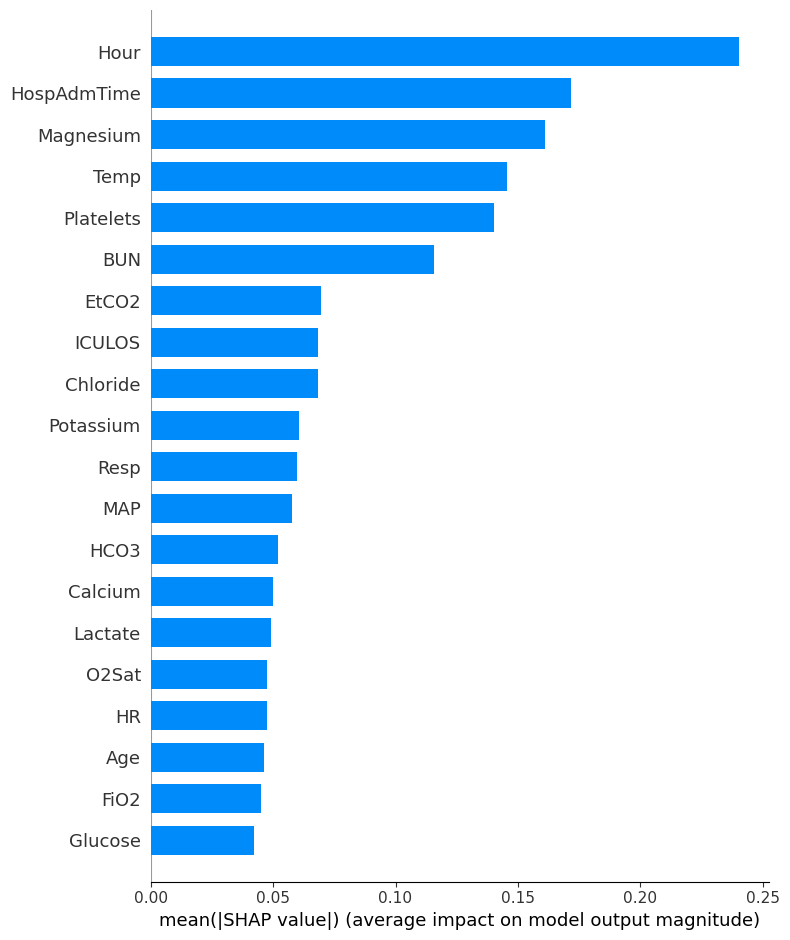

In [19]:
# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model, X_train, X_test)

# Autres essais

In [20]:
# Essai de la nouvelle fonction objective_v2 ()

# Calcule des meilleurs hyperparamètres
best_params, study = perform_hyperparameter_optimization(X_train, y_train, objective_v2, n_trials=100)
print("Meilleurs hyperparamètres:", best_params)
study_filename = 'optuna_study_0608.pkl'
save_study(study, study_filename)

[I 2024-08-06 12:12:06,462] A new study created in memory with name: no-name-90ce5f4e-9487-4a96-b6f5-152b9375f882
[I 2024-08-06 12:13:24,589] Trial 0 finished with value: 0.5545608574684938 and parameters: {'learning_rate': 0.3807947176588889, 'max_depth': 15, 'n_estimators': 197, 'min_child_weight': 6, 'gamma': 0.7885330158077583, 'subsample': 0.16443457513284063}. Best is trial 0 with value: 0.5545608574684938.
[I 2024-08-06 12:15:12,859] Trial 1 finished with value: 0.5629404404243651 and parameters: {'learning_rate': 0.06750277604651747, 'max_depth': 14, 'n_estimators': 170, 'min_child_weight': 8, 'gamma': 0.11271662653605422, 'subsample': 0.9702107536403743}. Best is trial 1 with value: 0.5629404404243651.
[I 2024-08-06 12:15:31,409] Trial 2 finished with value: 0.5427155126594173 and parameters: {'learning_rate': 0.8341182143924175, 'max_depth': 4, 'n_estimators': 86, 'min_child_weight': 2, 'gamma': 1.5281687923680933, 'subsample': 0.5295088673159155}. Best is trial 1 with value:

[I 2024-08-06 12:33:34,661] Trial 27 finished with value: 0.5591168955106472 and parameters: {'learning_rate': 0.12953653974103696, 'max_depth': 7, 'n_estimators': 220, 'min_child_weight': 1, 'gamma': 1.288152161757146, 'subsample': 0.10974705856016845}. Best is trial 22 with value: 0.6212634845515278.
[I 2024-08-06 12:34:06,672] Trial 28 finished with value: 0.5596955806781967 and parameters: {'learning_rate': 0.24102088392909934, 'max_depth': 5, 'n_estimators': 158, 'min_child_weight': 7, 'gamma': 1.800857455270364, 'subsample': 0.27581298507702606}. Best is trial 22 with value: 0.6212634845515278.
[I 2024-08-06 12:34:36,190] Trial 29 finished with value: 0.5737498276908753 and parameters: {'learning_rate': 0.3709405281777773, 'max_depth': 2, 'n_estimators': 203, 'min_child_weight': 6, 'gamma': 0.8529900234166172, 'subsample': 0.14545076633323986}. Best is trial 22 with value: 0.6212634845515278.
[I 2024-08-06 12:35:32,609] Trial 30 finished with value: 0.5880309180682405 and paramet

[I 2024-08-06 12:48:49,780] Trial 54 finished with value: 0.583232757582299 and parameters: {'learning_rate': 0.16664923150259253, 'max_depth': 3, 'n_estimators': 208, 'min_child_weight': 6, 'gamma': 2.665570083780273, 'subsample': 0.9456824942715369}. Best is trial 41 with value: 0.6599646668904227.
[I 2024-08-06 12:49:21,606] Trial 55 finished with value: 0.6386691375059309 and parameters: {'learning_rate': 0.01095994752608084, 'max_depth': 2, 'n_estimators': 197, 'min_child_weight': 8, 'gamma': 1.3646707040288129, 'subsample': 0.8325739606550563}. Best is trial 41 with value: 0.6599646668904227.
[I 2024-08-06 12:50:03,230] Trial 56 finished with value: 0.5942259530697981 and parameters: {'learning_rate': 0.04735243123120313, 'max_depth': 4, 'n_estimators': 237, 'min_child_weight': 7, 'gamma': 2.8636583340904456, 'subsample': 0.8556882472705379}. Best is trial 41 with value: 0.6599646668904227.
[I 2024-08-06 12:50:45,652] Trial 57 finished with value: 0.5952891567061549 and parameter

[I 2024-08-06 13:06:42,475] Trial 82 finished with value: 0.5916842735946882 and parameters: {'learning_rate': 0.0653578803979407, 'max_depth': 3, 'n_estimators': 238, 'min_child_weight': 4, 'gamma': 1.755669541451374, 'subsample': 0.8253984255460349}. Best is trial 41 with value: 0.6599646668904227.
[I 2024-08-06 13:07:18,677] Trial 83 finished with value: 0.6486634053400934 and parameters: {'learning_rate': 0.012711663793687822, 'max_depth': 2, 'n_estimators': 247, 'min_child_weight': 4, 'gamma': 1.5905727468844728, 'subsample': 0.7303312216085723}. Best is trial 41 with value: 0.6599646668904227.
[I 2024-08-06 13:07:54,640] Trial 84 finished with value: 0.6501441610615342 and parameters: {'learning_rate': 0.045475551397627004, 'max_depth': 2, 'n_estimators': 246, 'min_child_weight': 5, 'gamma': 2.094773236440123, 'subsample': 0.4738066578030957}. Best is trial 41 with value: 0.6599646668904227.
[I 2024-08-06 13:08:29,250] Trial 85 finished with value: 0.6441181153493962 and paramete

Meilleurs hyperparamètres: {'learning_rate': 0.012157970946775105, 'max_depth': 4, 'n_estimators': 197, 'min_child_weight': 8, 'gamma': 2.0597590551500726, 'subsample': 0.03252746655800639}


In [22]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0608_v2.joblib'
xgbc_model_v2 = train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path)


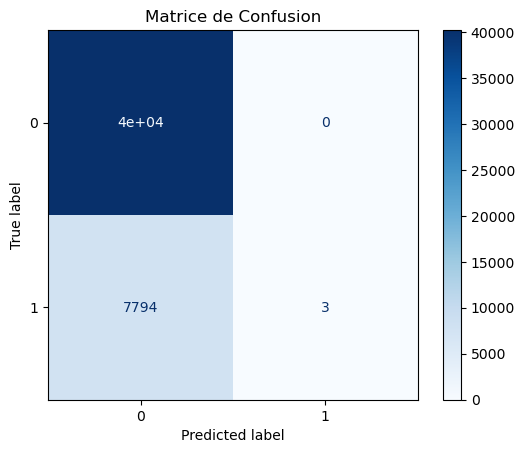

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     40198
           1       1.00      0.00      0.00      7797

    accuracy                           0.84     47995
   macro avg       0.92      0.50      0.46     47995
weighted avg       0.86      0.84      0.76     47995



In [25]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate_v2(xgbc_model_v2, X_test, y_test)
print(evaluation_report)

# Rebalancer les données d'entraintement

In [26]:
def balance_classes(df, target_column, method='undersample', random_state=123):
    """
    Équilibre les classes dans un DataFrame en sous-échantillonnant la classe majoritaire ou 
    en sur-échantillonnant la classe minoritaire selon le paramètre 'method'.

    Args:
    df (DataFrame): Le DataFrame à équilibrer.
    target_column (str): Nom de la colonne contenant les étiquettes de classe.
    method (str): Méthode d'équilibrage, 'undersample' pour sous-échantillonnage ou 'oversample' pour sur-échantillonnage.
    random_state (int): Graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    DataFrame: Un DataFrame où les classes sont équilibrées.
    """
    # Identifier les classes majoritaire et minoritaire
    class_counts = df[target_column].value_counts()
    major_class_label = class_counts.idxmax()
    minor_class_label = class_counts.idxmin()

    major_class = df[df[target_column] == major_class_label]
    minor_class = df[df[target_column] == minor_class_label]

    if method == 'undersample':
        # Sous-échantillonnage de la classe majoritaire
        resampled_major_class = resample(major_class,
                                         replace=False,
                                         n_samples=len(minor_class),
                                         random_state=random_state)
        balanced_df = pd.concat([resampled_major_class, minor_class])
    elif method == 'oversample':
        # Sur-échantillonnage de la classe minoritaire
        resampled_minor_class = resample(minor_class,
                                         replace=True,
                                         n_samples=len(major_class),
                                         random_state=random_state)
        balanced_df = pd.concat([major_class, resampled_minor_class])

    return balanced_df

In [28]:
balanced_data = balance_classes(data, 'SepsisLabel_Previous')
display_basic_info(balanced_data)

Shape of the DataFrame: (76698, 41)

Numbre of unique patients : 4766

Columns in the DataFrame: Index(['Patient_ID', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'Hour', 'HR',
       'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess',
       'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
       'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
       'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
       'SepsisLabel_Previous'],
      dtype='object')

Data Types:
 Patient_ID                int64
Age                     float64
Gender                    int64
HospAdmTime             float64
ICULOS                    int64
Hour                      int64
HR                      float64
O2Sat                   float64
Temp                    float64
SBP                     float64
MAP                     float64
DBP                     floa

'Descriptive Statistics:'

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel_Previous
count,76698.000000,76698.000000,76698.000000,76698.000000,76698.000000,76698.000000,76698.000000,76698.000000,76698.000000,76698.000000,...,76698.000000,76698.000000,76698.000000,76698.000000,76698.000000,76698.000000,76698.000000,76698.000000,76698.000000,76698.000000
mean,44283.233370,62.811209,0.602024,-79.196511,54.607825,52.668753,88.747087,97.101963,37.099253,121.678833,...,4.119427,2.096799,8.820191,30.395769,10.190928,37.769833,12.645071,308.920530,190.781835,0.500000
std,47726.916981,15.796181,0.489484,245.716639,55.422218,55.431988,18.096332,3.411811,0.856070,23.661621,...,0.581055,4.335241,14.857920,4.983097,1.729845,21.648899,6.771991,171.093178,109.065411,0.500003
min,9.000000,17.000000,0.000000,-5366.860000,1.000000,0.000000,20.000000,20.000000,29.375000,24.000000,...,2.000000,0.100000,0.010000,10.816667,3.416667,18.404348,0.100000,35.000000,2.000000,0.000000
25%,7857.000000,53.000000,0.000000,-68.710000,16.000000,14.000000,76.000000,96.000000,36.566667,104.000000,...,3.750000,0.500000,0.400000,26.963727,9.000000,28.000000,8.700000,196.000000,115.800000,0.000000
50%,15487.000000,65.000000,1.000000,-4.635000,35.000000,33.000000,88.000000,98.000000,37.100000,119.000000,...,4.042857,0.900000,1.720000,29.900000,10.045833,31.543739,11.600000,261.000000,170.000000,0.500000
75%,105496.000000,74.560000,1.000000,-0.030000,74.000000,72.000000,100.000000,100.000000,37.670000,136.000000,...,4.400000,1.700000,15.500000,33.300000,11.200000,38.200000,15.234783,373.000000,241.000000,1.000000
max,119994.000000,100.000000,1.000000,16.020000,336.000000,335.000000,219.000000,100.000000,41.920000,276.000000,...,11.500000,45.900000,200.000000,64.600000,22.817391,250.000000,174.700000,1383.000000,1081.000000,1.000000



Missing Values Per Column:
 Patient_ID              0
Age                     0
Gender                  0
HospAdmTime             0
ICULOS                  0
Hour                    0
HR                      0
O2Sat                   0
Temp                    0
SBP                     0
MAP                     0
DBP                     0
Resp                    0
EtCO2                   0
BaseExcess              0
HCO3                    0
FiO2                    0
pH                      0
PaCO2                   0
SaO2                    0
AST                     0
BUN                     0
Alkalinephos            0
Calcium                 0
Chloride                0
Creatinine              0
Bilirubin_direct        0
Glucose                 0
Lactate                 0
Magnesium               0
Phosphate               0
Potassium               0
Bilirubin_total         0
TroponinI               0
Hct                     0
Hgb                     0
PTT                     0
WBC      

'First 5 Rows of the DataFrame:'

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel_Previous
9217,1069,27.94,1,-0.02,11,9,87.0,98.0,36.500,98.0,...,4.400000,0.2,23.2,34.600000,12.500000,25.200000,10.800000,451.0,143.000000,0
155037,19099,81.99,1,-0.03,56,52,88.0,95.0,38.100,107.0,...,3.900000,0.7,4.8,24.000000,9.700000,25.400000,11.300000,450.0,108.000000,0
134696,16629,71.78,1,-0.03,17,15,69.0,100.0,37.044,148.0,...,4.645455,0.6,0.8,29.090909,9.872727,28.427273,10.081818,724.0,212.272727,0
88583,10958,69.38,1,-165.09,30,25,78.0,93.0,36.688,106.0,...,4.581818,0.3,24.3,26.327273,9.109091,39.057143,9.463636,255.0,188.521739,0
114725,14259,67.25,0,-0.02,16,15,86.0,100.0,36.695,131.0,...,3.458333,0.5,2.6,37.325000,12.316667,52.800000,19.816667,269.0,208.916667,0


In [30]:
X_train, y_train, X_test, y_test = split_train_test(balanced_data, 'SepsisLabel_Previous')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60494, 40), (60494,), (16204, 40), (16204,))

In [31]:
# Calcule des meilleurs hyperparamètres
best_params_v3, study = perform_hyperparameter_optimization(X_train, y_train, objective_v2, n_trials=100)
print("Meilleurs hyperparamètres:", best_params)
study_filename = 'optuna_study_0608_v3.pkl'
save_study(study, study_filename)

[I 2024-08-06 13:52:14,673] A new study created in memory with name: no-name-6119b2af-ee21-4e64-9f91-faad0459fb5c
[I 2024-08-06 13:52:45,836] Trial 0 finished with value: 0.3788965942231276 and parameters: {'learning_rate': 0.3807947176588889, 'max_depth': 15, 'n_estimators': 197, 'min_child_weight': 6, 'gamma': 0.7885330158077583, 'subsample': 0.16443457513284063}. Best is trial 0 with value: 0.3788965942231276.
[I 2024-08-06 13:53:37,755] Trial 1 finished with value: 0.2193686604754493 and parameters: {'learning_rate': 0.06750277604651747, 'max_depth': 14, 'n_estimators': 170, 'min_child_weight': 8, 'gamma': 0.11271662653605422, 'subsample': 0.9702107536403743}. Best is trial 0 with value: 0.3788965942231276.
[I 2024-08-06 13:53:44,563] Trial 2 finished with value: 0.20848596287797921 and parameters: {'learning_rate': 0.8341182143924175, 'max_depth': 4, 'n_estimators': 86, 'min_child_weight': 2, 'gamma': 1.5281687923680933, 'subsample': 0.5295088673159155}. Best is trial 0 with value

[I 2024-08-06 14:00:21,807] Trial 27 finished with value: 0.3911002094795764 and parameters: {'learning_rate': 0.9314175392333417, 'max_depth': 6, 'n_estimators': 189, 'min_child_weight': 7, 'gamma': 2.8353728264848717, 'subsample': 0.09778333918539892}. Best is trial 14 with value: 0.4464183453423184.
[I 2024-08-06 14:00:35,333] Trial 28 finished with value: 0.3475707017736403 and parameters: {'learning_rate': 0.72110801283259, 'max_depth': 7, 'n_estimators': 110, 'min_child_weight': 5, 'gamma': 2.0787462321262926, 'subsample': 0.19877917098500486}. Best is trial 14 with value: 0.4464183453423184.
[I 2024-08-06 14:00:59,040] Trial 29 finished with value: 0.29315066196351963 and parameters: {'learning_rate': 0.3236668591450469, 'max_depth': 11, 'n_estimators': 213, 'min_child_weight': 4, 'gamma': 3.816082929622672, 'subsample': 0.16730145002189306}. Best is trial 14 with value: 0.4464183453423184.
[I 2024-08-06 14:01:14,683] Trial 30 finished with value: 0.39781113103129967 and paramet

[I 2024-08-06 14:06:57,994] Trial 54 finished with value: 0.40573281252788135 and parameters: {'learning_rate': 0.8589520938647028, 'max_depth': 13, 'n_estimators': 119, 'min_child_weight': 3, 'gamma': 2.9270104459577384, 'subsample': 0.10208703216138931}. Best is trial 53 with value: 0.4538600803689213.
[I 2024-08-06 14:07:14,618] Trial 55 finished with value: 0.3979011414660053 and parameters: {'learning_rate': 0.996772258893754, 'max_depth': 11, 'n_estimators': 101, 'min_child_weight': 3, 'gamma': 3.1072028289996596, 'subsample': 0.14267596290009166}. Best is trial 53 with value: 0.4538600803689213.
[I 2024-08-06 14:07:23,525] Trial 56 finished with value: 0.39874222812478555 and parameters: {'learning_rate': 0.9537237402792909, 'max_depth': 12, 'n_estimators': 83, 'min_child_weight': 9, 'gamma': 2.6605851555033664, 'subsample': 0.04896056446769162}. Best is trial 53 with value: 0.4538600803689213.
[I 2024-08-06 14:07:34,928] Trial 57 finished with value: 0.2809072075796858 and para

[I 2024-08-06 14:13:13,622] Trial 81 finished with value: 0.40526067101574154 and parameters: {'learning_rate': 0.9425826676119726, 'max_depth': 10, 'n_estimators': 132, 'min_child_weight': 5, 'gamma': 3.4525764721508203, 'subsample': 0.03413926663484593}. Best is trial 71 with value: 0.4578441140096635.
[I 2024-08-06 14:13:26,032] Trial 82 finished with value: 0.4061917738419985 and parameters: {'learning_rate': 0.9708987445468569, 'max_depth': 10, 'n_estimators': 138, 'min_child_weight': 4, 'gamma': 3.2358722282885086, 'subsample': 0.05824862472477038}. Best is trial 71 with value: 0.4578441140096635.
[I 2024-08-06 14:13:39,216] Trial 83 finished with value: 0.3773907001858515 and parameters: {'learning_rate': 0.9353340027650865, 'max_depth': 11, 'n_estimators': 118, 'min_child_weight': 4, 'gamma': 0.07097851754838969, 'subsample': 0.08026493395475934}. Best is trial 71 with value: 0.4578441140096635.
[I 2024-08-06 14:13:48,410] Trial 84 finished with value: 0.44007225868219424 and p

Meilleurs hyperparamètres: {'learning_rate': 0.012157970946775105, 'max_depth': 4, 'n_estimators': 197, 'min_child_weight': 8, 'gamma': 2.0597590551500726, 'subsample': 0.03252746655800639}


In [32]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0608_v3.joblib'
xgbc_model_v3 = train_and_save_xgboost_classifier(X_train, y_train, best_params_v3, model_path)


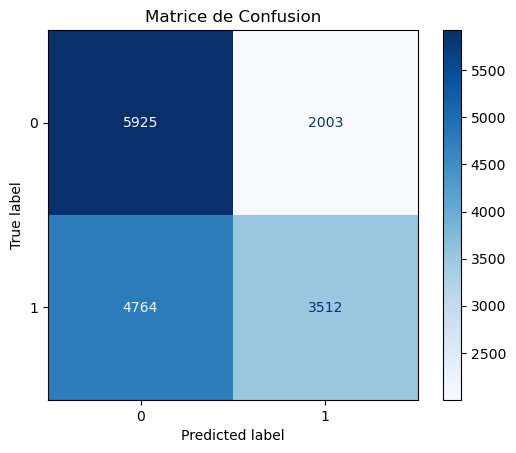

              precision    recall  f1-score   support

           0       0.55      0.75      0.64      7928
           1       0.64      0.42      0.51      8276

    accuracy                           0.58     16204
   macro avg       0.60      0.59      0.57     16204
weighted avg       0.60      0.58      0.57     16204



In [33]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate_v2(xgbc_model_v3, X_test, y_test)
print(evaluation_report)

 99%|===================| 16098/16204 [01:51<00:00]        

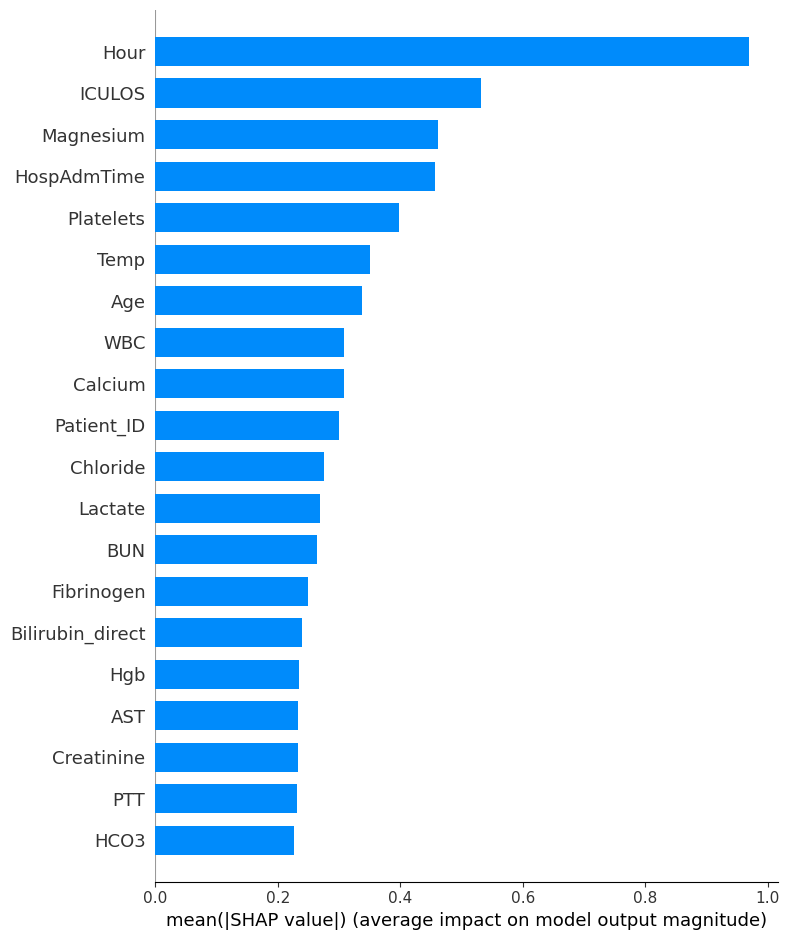

In [34]:
# En faisant le sous échantillonnage selon le nombre de linges, les performormances du modèle sont devenues équilibrées,
# mais restent insuffisantes.

# On remarque aussin certaines différences dans l'importance des variables dans les deux modèles.





# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model_v3, X_train, X_test)

# coordinnation des fonctions de recherche et d'entrainement

In [36]:
# Calcule des meilleurs hyperparamètres
best_params_v4, study = perform_hyperparameter_optimization(X_train, y_train, objective_v2, n_trials=100)
print("Meilleurs hyperparamètres:", best_params)
study_filename = 'optuna_study_0608_v4.pkl'
save_study(study, study_filename)

[I 2024-08-06 14:51:24,965] A new study created in memory with name: no-name-1bf6fc0f-4e0a-4bd4-84a7-8fd5a1e401dc
[I 2024-08-06 14:51:56,161] Trial 0 finished with value: 0.3788965942231276 and parameters: {'learning_rate': 0.3807947176588889, 'max_depth': 15, 'n_estimators': 197, 'min_child_weight': 6, 'gamma': 0.7885330158077583, 'subsample': 0.16443457513284063}. Best is trial 0 with value: 0.3788965942231276.
[I 2024-08-06 14:52:48,312] Trial 1 finished with value: 0.2193686604754493 and parameters: {'learning_rate': 0.06750277604651747, 'max_depth': 14, 'n_estimators': 170, 'min_child_weight': 8, 'gamma': 0.11271662653605422, 'subsample': 0.9702107536403743}. Best is trial 0 with value: 0.3788965942231276.
[I 2024-08-06 14:52:55,495] Trial 2 finished with value: 0.20848596287797921 and parameters: {'learning_rate': 0.8341182143924175, 'max_depth': 4, 'n_estimators': 86, 'min_child_weight': 2, 'gamma': 1.5281687923680933, 'subsample': 0.5295088673159155}. Best is trial 0 with value

[I 2024-08-06 14:58:03,344] Trial 27 finished with value: 0.3911002094795764 and parameters: {'learning_rate': 0.9314175392333417, 'max_depth': 6, 'n_estimators': 189, 'min_child_weight': 7, 'gamma': 2.8353728264848717, 'subsample': 0.09778333918539892}. Best is trial 14 with value: 0.4464183453423184.
[I 2024-08-06 14:58:13,032] Trial 28 finished with value: 0.3475707017736403 and parameters: {'learning_rate': 0.72110801283259, 'max_depth': 7, 'n_estimators': 110, 'min_child_weight': 5, 'gamma': 2.0787462321262926, 'subsample': 0.19877917098500486}. Best is trial 14 with value: 0.4464183453423184.
[I 2024-08-06 14:58:29,541] Trial 29 finished with value: 0.29315066196351963 and parameters: {'learning_rate': 0.3236668591450469, 'max_depth': 11, 'n_estimators': 213, 'min_child_weight': 4, 'gamma': 3.816082929622672, 'subsample': 0.16730145002189306}. Best is trial 14 with value: 0.4464183453423184.
[I 2024-08-06 14:58:40,884] Trial 30 finished with value: 0.39781113103129967 and paramet

[I 2024-08-06 15:02:45,932] Trial 54 finished with value: 0.40573281252788135 and parameters: {'learning_rate': 0.8589520938647028, 'max_depth': 13, 'n_estimators': 119, 'min_child_weight': 3, 'gamma': 2.9270104459577384, 'subsample': 0.10208703216138931}. Best is trial 53 with value: 0.4538600803689213.
[I 2024-08-06 15:02:59,173] Trial 55 finished with value: 0.3979011414660053 and parameters: {'learning_rate': 0.996772258893754, 'max_depth': 11, 'n_estimators': 101, 'min_child_weight': 3, 'gamma': 3.1072028289996596, 'subsample': 0.14267596290009166}. Best is trial 53 with value: 0.4538600803689213.
[I 2024-08-06 15:03:05,341] Trial 56 finished with value: 0.39874222812478555 and parameters: {'learning_rate': 0.9537237402792909, 'max_depth': 12, 'n_estimators': 83, 'min_child_weight': 9, 'gamma': 2.6605851555033664, 'subsample': 0.04896056446769162}. Best is trial 53 with value: 0.4538600803689213.
[I 2024-08-06 15:03:13,605] Trial 57 finished with value: 0.2809072075796858 and para

[I 2024-08-06 15:07:18,737] Trial 81 finished with value: 0.40526067101574154 and parameters: {'learning_rate': 0.9425826676119726, 'max_depth': 10, 'n_estimators': 132, 'min_child_weight': 5, 'gamma': 3.4525764721508203, 'subsample': 0.03413926663484593}. Best is trial 71 with value: 0.4578441140096635.
[I 2024-08-06 15:07:29,964] Trial 82 finished with value: 0.4061917738419985 and parameters: {'learning_rate': 0.9708987445468569, 'max_depth': 10, 'n_estimators': 138, 'min_child_weight': 4, 'gamma': 3.2358722282885086, 'subsample': 0.05824862472477038}. Best is trial 71 with value: 0.4578441140096635.
[I 2024-08-06 15:07:40,330] Trial 83 finished with value: 0.3773907001858515 and parameters: {'learning_rate': 0.9353340027650865, 'max_depth': 11, 'n_estimators': 118, 'min_child_weight': 4, 'gamma': 0.07097851754838969, 'subsample': 0.08026493395475934}. Best is trial 71 with value: 0.4578441140096635.
[I 2024-08-06 15:07:46,786] Trial 84 finished with value: 0.44007225868219424 and p

Meilleurs hyperparamètres: {'learning_rate': 0.012157970946775105, 'max_depth': 4, 'n_estimators': 197, 'min_child_weight': 8, 'gamma': 2.0597590551500726, 'subsample': 0.03252746655800639}


In [43]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0608_v4.joblib'
xgbc_model_v4 = train_and_save_xgboost_classifier_v2(X_train, y_train, best_params_v4, model_path)


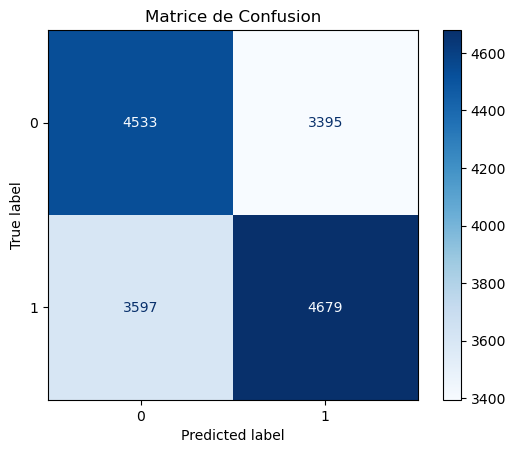

              precision    recall  f1-score   support

           0       0.56      0.57      0.56      7928
           1       0.58      0.57      0.57      8276

    accuracy                           0.57     16204
   macro avg       0.57      0.57      0.57     16204
weighted avg       0.57      0.57      0.57     16204



In [44]:
# Prédiction et évaluation
evaluation_report = predict_and_evaluate_v2(xgbc_model_v4, X_test, y_test)
print(evaluation_report)

 99%|===================| 16114/16204 [00:55<00:00]        

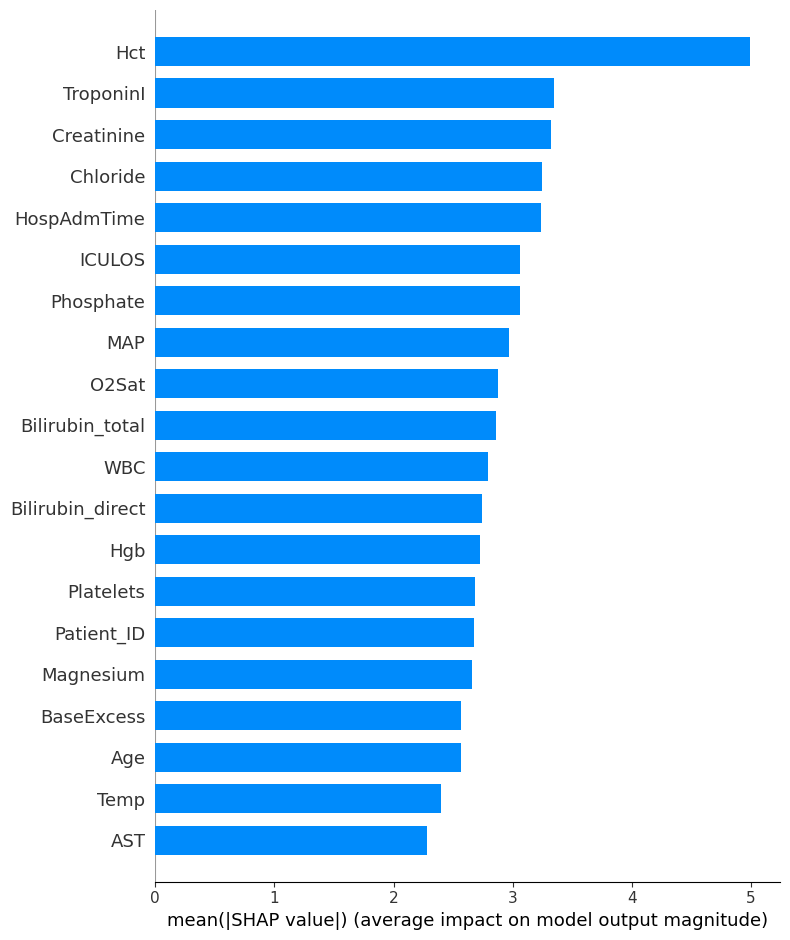

In [46]:
# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model_v4, X_train, X_test)

# Modifications des hyper paramètres

Réduction du learning_rate

In [41]:
def objective_v5(trial, X, y, cv=7):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'n_estimators': trial.suggest_int('n_estimators', 50, 250),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 5),
        'subsample': trial.suggest_float('subsample', 0.01, 1)
    }
    clf = create_xgb_classifier(params)
    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    return np.mean(score)

In [42]:
# Calcule des meilleurs hyperparamètres
best_params_v5, study = perform_hyperparameter_optimization(X_train, y_train, objective_v5, n_trials=100)
print("Meilleurs hyperparamètres:", best_params_v5)
study_filename = 'optuna_study_0608_v5.pkl'
save_study(study, study_filename)

[I 2024-08-06 22:30:52,301] A new study created in memory with name: no-name-ecdc3208-a0ce-458b-a780-912a26034a39
[I 2024-08-06 22:31:35,239] Trial 0 finished with value: 0.19485570574283576 and parameters: {'learning_rate': 0.03807947176588889, 'max_depth': 15, 'n_estimators': 197, 'min_child_weight': 6, 'gamma': 0.7885330158077583, 'subsample': 0.16443457513284063}. Best is trial 0 with value: 0.19485570574283576.
[I 2024-08-06 22:32:55,678] Trial 1 finished with value: 0.1448866948878645 and parameters: {'learning_rate': 0.006750277604651747, 'max_depth': 14, 'n_estimators': 170, 'min_child_weight': 8, 'gamma': 0.11271662653605422, 'subsample': 0.9702107536403743}. Best is trial 0 with value: 0.19485570574283576.
[I 2024-08-06 22:33:02,593] Trial 2 finished with value: 0.12550741831698967 and parameters: {'learning_rate': 0.08341182143924175, 'max_depth': 4, 'n_estimators': 86, 'min_child_weight': 2, 'gamma': 1.5281687923680933, 'subsample': 0.5295088673159155}. Best is trial 0 with

[I 2024-08-06 22:39:33,578] Trial 27 finished with value: 0.19223111494791345 and parameters: {'learning_rate': 0.0914108271772728, 'max_depth': 9, 'n_estimators': 112, 'min_child_weight': 3, 'gamma': 4.239436836503811, 'subsample': 0.11203724934539906}. Best is trial 14 with value: 0.281060716131375.
[I 2024-08-06 22:39:44,280] Trial 28 finished with value: 0.1487102725694889 and parameters: {'learning_rate': 0.08287993485420214, 'max_depth': 7, 'n_estimators': 82, 'min_child_weight': 2, 'gamma': 3.680323627211692, 'subsample': 0.23396505247901375}. Best is trial 14 with value: 0.281060716131375.
[I 2024-08-06 22:40:11,033] Trial 29 finished with value: 0.18457091951534768 and parameters: {'learning_rate': 0.09240945713818112, 'max_depth': 15, 'n_estimators': 213, 'min_child_weight': 5, 'gamma': 4.448886533135866, 'subsample': 0.16730174532211917}. Best is trial 14 with value: 0.281060716131375.
[I 2024-08-06 22:40:32,455] Trial 30 finished with value: 0.18985065553551989 and paramete

[I 2024-08-06 22:46:16,833] Trial 54 finished with value: 0.17500422783062045 and parameters: {'learning_rate': 0.04024903020348171, 'max_depth': 14, 'n_estimators': 75, 'min_child_weight': 4, 'gamma': 4.039355561788685, 'subsample': 0.14065091559189066}. Best is trial 33 with value: 0.31380565597421733.
[I 2024-08-06 22:46:36,038] Trial 55 finished with value: 0.16953512213652583 and parameters: {'learning_rate': 0.058021228200413735, 'max_depth': 13, 'n_estimators': 80, 'min_child_weight': 1, 'gamma': 4.984198646982892, 'subsample': 0.18575739114831102}. Best is trial 33 with value: 0.31380565597421733.
[I 2024-08-06 22:46:47,951] Trial 56 finished with value: 0.1738761122360347 and parameters: {'learning_rate': 0.05285808878234231, 'max_depth': 14, 'n_estimators': 67, 'min_child_weight': 9, 'gamma': 3.5652709173512425, 'subsample': 0.09775192880639283}. Best is trial 33 with value: 0.31380565597421733.
[I 2024-08-06 22:46:58,021] Trial 57 finished with value: 0.19879748275840575 and

[I 2024-08-06 22:53:37,958] Trial 81 finished with value: 0.30074677255855253 and parameters: {'learning_rate': 0.08807919607513134, 'max_depth': 13, 'n_estimators': 83, 'min_child_weight': 2, 'gamma': 4.1520723007502065, 'subsample': 0.014355531038610656}. Best is trial 78 with value: 0.3280143759267098.
[I 2024-08-06 22:53:53,674] Trial 82 finished with value: 0.20706710443507684 and parameters: {'learning_rate': 0.08863072736005374, 'max_depth': 14, 'n_estimators': 84, 'min_child_weight': 2, 'gamma': 4.215355776286997, 'subsample': 0.07459060277664259}. Best is trial 78 with value: 0.3280143759267098.
[I 2024-08-06 22:54:08,393] Trial 83 finished with value: 0.22778736191554733 and parameters: {'learning_rate': 0.08026332478468892, 'max_depth': 13, 'n_estimators': 98, 'min_child_weight': 1, 'gamma': 4.7660674784817205, 'subsample': 0.03995709294491953}. Best is trial 78 with value: 0.3280143759267098.
[I 2024-08-06 22:54:22,466] Trial 84 finished with value: 0.3411451419541604 and p

Meilleurs hyperparamètres: {'learning_rate': 0.08995019805420194, 'max_depth': 13, 'n_estimators': 143, 'min_child_weight': 1, 'gamma': 1.3372586583391028, 'subsample': 0.01101736043240244}


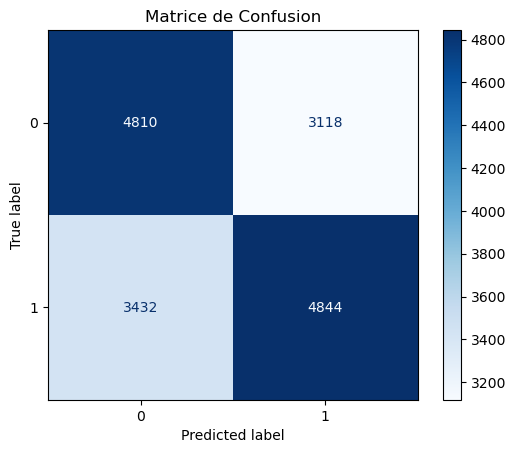

              precision    recall  f1-score   support

           0       0.58      0.61      0.59      7928
           1       0.61      0.59      0.60      8276

    accuracy                           0.60     16204
   macro avg       0.60      0.60      0.60     16204
weighted avg       0.60      0.60      0.60     16204



In [45]:
"""
    Les performances sont légèrement améliorée après la réduction du learning rate

"""



# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0608_v5.joblib'
xgbc_model_v5 = train_and_save_xgboost_classifier_v2(X_train, y_train, best_params_v5, model_path)

# Prédiction et évaluation
evaluation_report = predict_and_evaluate_v2(xgbc_model_v5, X_test, y_test)
print(evaluation_report)

100%|===================| 16194/16204 [06:48<00:00]        

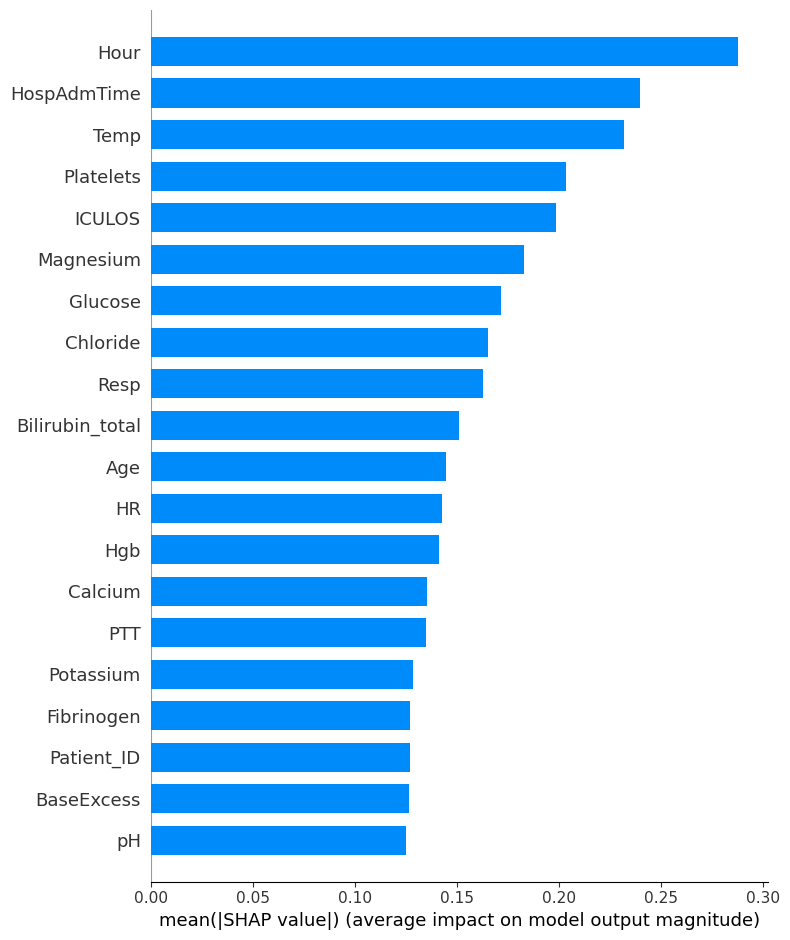

In [52]:
# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model_v5, X_train, X_test)

Augmentation de n_estimators

In [48]:
def objective_v6(trial, X, y, cv=7):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 5),
        'subsample': trial.suggest_float('subsample', 0.01, 1)
    }
    clf = create_xgb_classifier(params)
    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    return np.mean(score)

In [49]:
# Calcule des meilleurs hyperparamètres
best_params_v6, study = perform_hyperparameter_optimization(X_train, y_train, objective_v6, n_trials=100)
print("Meilleurs hyperparamètres:", best_params_v6)
study_filename = 'optuna_study_0608_v6.pkl'
save_study(study, study_filename)

[I 2024-08-06 23:24:19,464] A new study created in memory with name: no-name-f95fd3f7-1b9e-415a-9cf3-8084731a2c77
[I 2024-08-06 23:25:36,382] Trial 0 finished with value: 0.22571376348918532 and parameters: {'learning_rate': 0.03807947176588889, 'max_depth': 15, 'n_estimators': 393, 'min_child_weight': 6, 'gamma': 0.7885330158077583, 'subsample': 0.16443457513284063}. Best is trial 0 with value: 0.22571376348918532.
[I 2024-08-06 23:28:10,145] Trial 1 finished with value: 0.16655606413201826 and parameters: {'learning_rate': 0.006750277604651747, 'max_depth': 14, 'n_estimators': 341, 'min_child_weight': 8, 'gamma': 0.11271662653605422, 'subsample': 0.9702107536403743}. Best is trial 0 with value: 0.22571376348918532.
[I 2024-08-06 23:28:22,423] Trial 2 finished with value: 0.12723622218236413 and parameters: {'learning_rate': 0.08341182143924175, 'max_depth': 4, 'n_estimators': 172, 'min_child_weight': 2, 'gamma': 1.5281687923680933, 'subsample': 0.5295088673159155}. Best is trial 0 wi

[I 2024-08-06 23:44:23,585] Trial 27 finished with value: 0.23323846473234575 and parameters: {'learning_rate': 0.09900555571531994, 'max_depth': 11, 'n_estimators': 313, 'min_child_weight': 7, 'gamma': 3.792491915736754, 'subsample': 0.09411355652123973}. Best is trial 12 with value: 0.3548571371536548.
[I 2024-08-06 23:45:15,722] Trial 28 finished with value: 0.2548888078159174 and parameters: {'learning_rate': 0.08879789703289474, 'max_depth': 13, 'n_estimators': 365, 'min_child_weight': 5, 'gamma': 2.0787462321262926, 'subsample': 0.1595399870842136}. Best is trial 12 with value: 0.3548571371536548.
[I 2024-08-06 23:46:06,323] Trial 29 finished with value: 0.19351386526335415 and parameters: {'learning_rate': 0.0770294111613915, 'max_depth': 15, 'n_estimators': 466, 'min_child_weight': 4, 'gamma': 2.737400866804686, 'subsample': 0.28083655599858415}. Best is trial 12 with value: 0.3548571371536548.
[I 2024-08-06 23:46:49,945] Trial 30 finished with value: 0.19150603017772655 and pa

[I 2024-08-06 23:59:14,216] Trial 54 finished with value: 0.20889554054962217 and parameters: {'learning_rate': 0.09049110792090947, 'max_depth': 11, 'n_estimators': 212, 'min_child_weight': 4, 'gamma': 3.428964233380907, 'subsample': 0.14067877995672232}. Best is trial 12 with value: 0.3548571371536548.
[I 2024-08-06 23:59:41,852] Trial 55 finished with value: 0.22186472721560718 and parameters: {'learning_rate': 0.08721472127225477, 'max_depth': 8, 'n_estimators': 251, 'min_child_weight': 5, 'gamma': 3.0717572160196904, 'subsample': 0.08115123944078363}. Best is trial 12 with value: 0.3548571371536548.
[I 2024-08-07 00:00:14,900] Trial 56 finished with value: 0.23276553620330612 and parameters: {'learning_rate': 0.09724498433592492, 'max_depth': 10, 'n_estimators': 283, 'min_child_weight': 9, 'gamma': 3.288108951965631, 'subsample': 0.10691742096729918}. Best is trial 12 with value: 0.3548571371536548.
[I 2024-08-07 00:00:50,011] Trial 57 finished with value: 0.19049270799681745 and 

[I 2024-08-07 00:16:44,623] Trial 81 finished with value: 0.24154245670277774 and parameters: {'learning_rate': 0.09429196802381895, 'max_depth': 11, 'n_estimators': 337, 'min_child_weight': 4, 'gamma': 4.047336420955835, 'subsample': 0.06907817181016809}. Best is trial 12 with value: 0.3548571371536548.
[I 2024-08-07 00:17:13,432] Trial 82 finished with value: 0.2702211619412242 and parameters: {'learning_rate': 0.09766331275761819, 'max_depth': 10, 'n_estimators': 273, 'min_child_weight': 4, 'gamma': 4.531784787309641, 'subsample': 0.03566281806479864}. Best is trial 12 with value: 0.3548571371536548.
[I 2024-08-07 00:17:46,918] Trial 83 finished with value: 0.22923203546136547 and parameters: {'learning_rate': 0.09162132174682895, 'max_depth': 11, 'n_estimators': 313, 'min_child_weight': 3, 'gamma': 4.239086206698018, 'subsample': 0.07171747410001768}. Best is trial 12 with value: 0.3548571371536548.
[I 2024-08-07 00:18:13,442] Trial 84 finished with value: 0.33700146934295566 and p

Meilleurs hyperparamètres: {'learning_rate': 0.09736841202861325, 'max_depth': 9, 'n_estimators': 498, 'min_child_weight': 4, 'gamma': 3.4065545578134677, 'subsample': 0.014182873003133855}


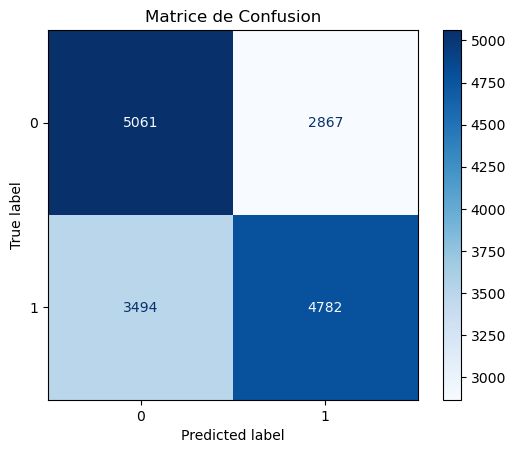

              precision    recall  f1-score   support

           0       0.59      0.64      0.61      7928
           1       0.63      0.58      0.60      8276

    accuracy                           0.61     16204
   macro avg       0.61      0.61      0.61     16204
weighted avg       0.61      0.61      0.61     16204



In [50]:
"""
    L'augmentation du nombre d'estimateurs (nombre d'arbres) à légèrement améliorer les performances

"""



# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0608_v6.joblib'
xgbc_model_v6 = train_and_save_xgboost_classifier_v2(X_train, y_train, best_params_v6, model_path)

# Prédiction et évaluation
evaluation_report = predict_and_evaluate_v2(xgbc_model_v6, X_test, y_test)
print(evaluation_report)

100%|===================| 16194/16204 [13:45<00:00]        

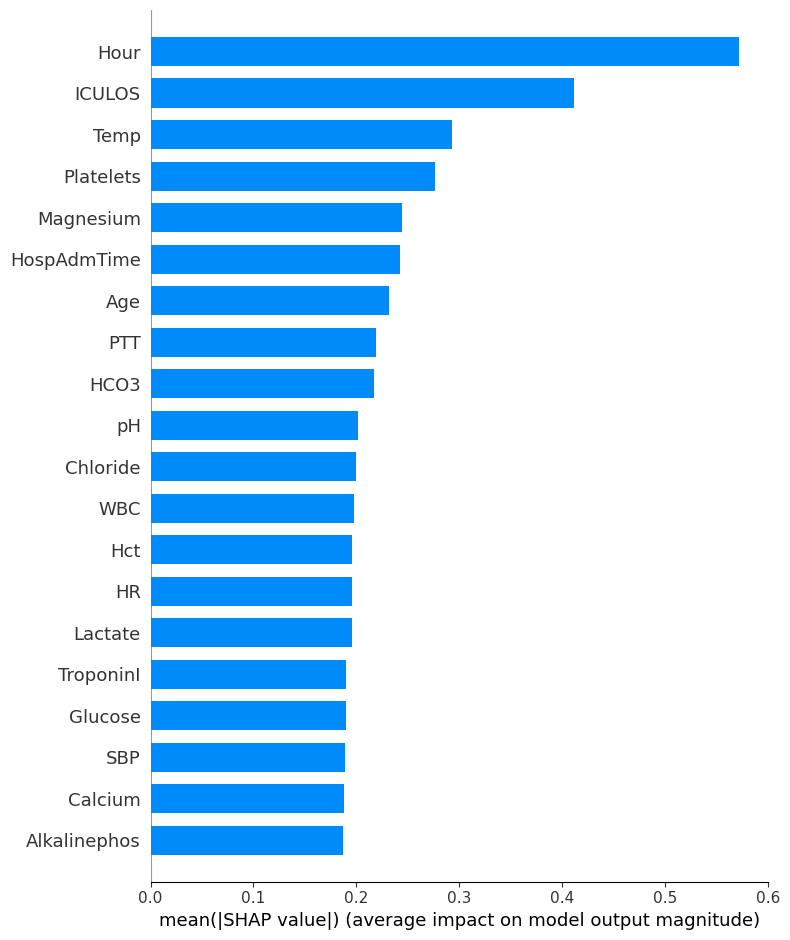

In [51]:
# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model_v6, X_train, X_test)

 Ajustement de max_depth

In [53]:
def objective_v7(trial, X, y, cv=7):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10), 
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 5),
        'subsample': trial.suggest_float('subsample', 0.01, 1)
    }
    clf = create_xgb_classifier(params)
    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    return np.mean(score)

In [55]:
# Calcule des meilleurs hyperparamètres
best_params_v7, study = perform_hyperparameter_optimization(X_train, y_train, objective_v7, n_trials=100)
print("Meilleurs hyperparamètres:", best_params_v7)
study_filename = 'optuna_study_0608_v7.pkl'
save_study(study, study_filename)

[I 2024-08-07 01:08:54,779] A new study created in memory with name: no-name-0053a3ed-336c-43f0-a7de-a744c520a9aa
[I 2024-08-07 01:09:53,614] Trial 0 finished with value: 0.19396098846834983 and parameters: {'learning_rate': 0.03807947176588889, 'max_depth': 10, 'n_estimators': 393, 'min_child_weight': 6, 'gamma': 0.7885330158077583, 'subsample': 0.16443457513284063}. Best is trial 0 with value: 0.19396098846834983.
[I 2024-08-07 01:11:00,870] Trial 1 finished with value: 0.13853529345728835 and parameters: {'learning_rate': 0.006750277604651747, 'max_depth': 9, 'n_estimators': 341, 'min_child_weight': 8, 'gamma': 0.11271662653605422, 'subsample': 0.9702107536403743}. Best is trial 0 with value: 0.19396098846834983.
[I 2024-08-07 01:11:12,947] Trial 2 finished with value: 0.12723622218236413 and parameters: {'learning_rate': 0.08341182143924175, 'max_depth': 4, 'n_estimators': 172, 'min_child_weight': 2, 'gamma': 1.5281687923680933, 'subsample': 0.5295088673159155}. Best is trial 0 wit

[I 2024-08-07 01:24:46,174] Trial 27 finished with value: 0.22294968933390533 and parameters: {'learning_rate': 0.09900555571531994, 'max_depth': 8, 'n_estimators': 313, 'min_child_weight': 7, 'gamma': 3.792491915736754, 'subsample': 0.09411355652123973}. Best is trial 12 with value: 0.36023932630380545.
[I 2024-08-07 01:25:23,196] Trial 28 finished with value: 0.21047839223379736 and parameters: {'learning_rate': 0.08879789703289474, 'max_depth': 7, 'n_estimators': 365, 'min_child_weight': 5, 'gamma': 2.0787462321262926, 'subsample': 0.1595399870842136}. Best is trial 12 with value: 0.36023932630380545.
[I 2024-08-07 01:25:58,682] Trial 29 finished with value: 0.1594424274471819 and parameters: {'learning_rate': 0.0770294111613915, 'max_depth': 5, 'n_estimators': 466, 'min_child_weight': 4, 'gamma': 2.737400866804686, 'subsample': 0.28083655599858415}. Best is trial 12 with value: 0.36023932630380545.
[I 2024-08-07 01:26:34,122] Trial 30 finished with value: 0.16632869090009236 and pa

[I 2024-08-07 01:37:50,346] Trial 54 finished with value: 0.2214961325532213 and parameters: {'learning_rate': 0.09491988661843392, 'max_depth': 8, 'n_estimators': 308, 'min_child_weight': 3, 'gamma': 3.154861162850058, 'subsample': 0.1419019940101289}. Best is trial 45 with value: 0.36709628167795133.
[I 2024-08-07 01:38:34,481] Trial 55 finished with value: 0.22533675663862035 and parameters: {'learning_rate': 0.08721472127225477, 'max_depth': 7, 'n_estimators': 499, 'min_child_weight': 4, 'gamma': 3.7950586548291465, 'subsample': 0.08198188994789361}. Best is trial 45 with value: 0.36709628167795133.
[I 2024-08-07 01:39:02,132] Trial 56 finished with value: 0.22637977004976242 and parameters: {'learning_rate': 0.09593677358248585, 'max_depth': 6, 'n_estimators': 332, 'min_child_weight': 9, 'gamma': 3.678312013878084, 'subsample': 0.050906710920314485}. Best is trial 45 with value: 0.36709628167795133.
[I 2024-08-07 01:39:34,394] Trial 57 finished with value: 0.18057409729733395 and 

[I 2024-08-07 01:49:48,311] Trial 81 finished with value: 0.32618974632094233 and parameters: {'learning_rate': 0.08723581718930383, 'max_depth': 6, 'n_estimators': 480, 'min_child_weight': 3, 'gamma': 3.0359898983195244, 'subsample': 0.014390760757743473}. Best is trial 45 with value: 0.36709628167795133.
[I 2024-08-07 01:50:09,412] Trial 82 finished with value: 0.17501920174915986 and parameters: {'learning_rate': 0.08315411470467848, 'max_depth': 4, 'n_estimators': 446, 'min_child_weight': 3, 'gamma': 3.2713262503021787, 'subsample': 0.06876558177246182}. Best is trial 45 with value: 0.36709628167795133.
[I 2024-08-07 01:50:35,646] Trial 83 finished with value: 0.2553254985809338 and parameters: {'learning_rate': 0.08575314460439278, 'max_depth': 5, 'n_estimators': 472, 'min_child_weight': 3, 'gamma': 3.6545672582822792, 'subsample': 0.03176895476845103}. Best is trial 45 with value: 0.36709628167795133.
[I 2024-08-07 01:51:08,610] Trial 84 finished with value: 0.27479691013865537 a

Meilleurs hyperparamètres: {'learning_rate': 0.09984129077877595, 'max_depth': 6, 'n_estimators': 464, 'min_child_weight': 2, 'gamma': 3.8757979957141595, 'subsample': 0.011865976181810118}


[0]	validation_0-logloss:0.68866
[1]	validation_0-logloss:0.68511


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-logloss:0.67947
[3]	validation_0-logloss:0.67693
[4]	validation_0-logloss:0.67280
[5]	validation_0-logloss:0.66938
[6]	validation_0-logloss:0.66741
[7]	validation_0-logloss:0.66507
[8]	validation_0-logloss:0.66481
[9]	validation_0-logloss:0.66295
[10]	validation_0-logloss:0.66195
[11]	validation_0-logloss:0.66237
[12]	validation_0-logloss:0.66169
[13]	validation_0-logloss:0.66177
[14]	validation_0-logloss:0.66214
[15]	validation_0-logloss:0.66314
[16]	validation_0-logloss:0.66187
[17]	validation_0-logloss:0.66249
[18]	validation_0-logloss:0.66061
[19]	validation_0-logloss:0.65963
[20]	validation_0-logloss:0.65838
[21]	validation_0-logloss:0.65883
[22]	validation_0-logloss:0.65993
[23]	validation_0-logloss:0.66039
[24]	validation_0-logloss:0.65918
[25]	validation_0-logloss:0.65904
[26]	validation_0-logloss:0.66011
[27]	validation_0-logloss:0.66010
[28]	validation_0-logloss:0.66034
[29]	validation_0-logloss:0.66016
[30]	validation_0-logloss:0.66030


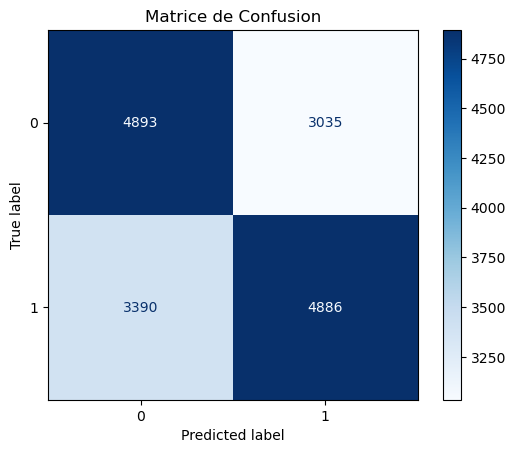

              precision    recall  f1-score   support

           0       0.59      0.62      0.60      7928
           1       0.62      0.59      0.60      8276

    accuracy                           0.60     16204
   macro avg       0.60      0.60      0.60     16204
weighted avg       0.60      0.60      0.60     16204



In [58]:
"""
    L'ajustement (diminution) de la taille des arbres (max_depth) affecte le modèle négativement 

"""



# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0608_v7.joblib'
xgbc_model_v7 = train_and_save_xgboost_classifier_v2(X_train, y_train, best_params_v7, model_path)

# Prédiction et évaluation
evaluation_report = predict_and_evaluate_v2(xgbc_model_v7, X_test, y_test)
print(evaluation_report)

 96%|=================== | 15557/16204 [00:15<00:00]       

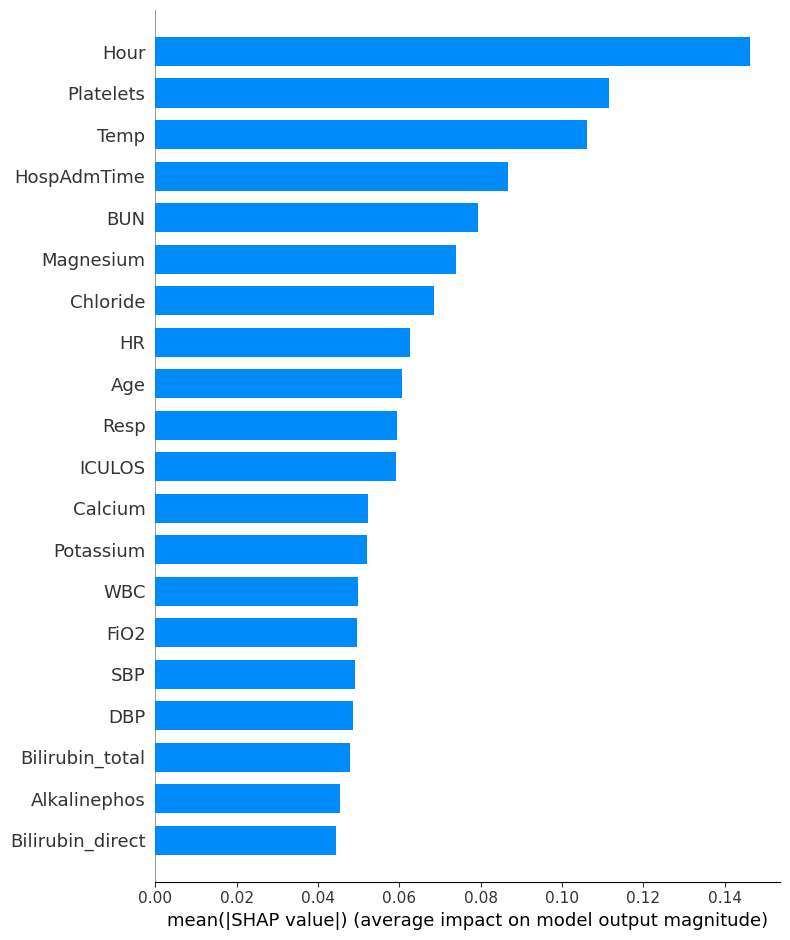

In [59]:
# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model_v7, X_train, X_test)

Exploration de subsample

In [60]:
def objective_v8(trial, X, y, cv=7):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10), 
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9)
    }
    clf = create_xgb_classifier(params)
    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    return np.mean(score)

In [61]:
# Calcule des meilleurs hyperparamètres
best_params_v8, study = perform_hyperparameter_optimization(X_train, y_train, objective_v8, n_trials=100)
print("Meilleurs hyperparamètres:", best_params_v8)
study_filename = 'optuna_study_0608_v8.pkl'
save_study(study, study_filename)

[I 2024-08-07 02:11:37,358] A new study created in memory with name: no-name-d6b137a0-66e1-4eca-81c8-a00e7b1d7d77
[I 2024-08-07 02:12:17,288] Trial 0 finished with value: 0.19022973904832893 and parameters: {'learning_rate': 0.03807947176588889, 'max_depth': 10, 'n_estimators': 393, 'min_child_weight': 6, 'gamma': 0.7885330158077583, 'subsample': 0.562397808134481}. Best is trial 0 with value: 0.19022973904832893.
[I 2024-08-07 02:13:11,884] Trial 1 finished with value: 0.13726309005840068 and parameters: {'learning_rate': 0.006750277604651747, 'max_depth': 9, 'n_estimators': 341, 'min_child_weight': 8, 'gamma': 0.11271662653605422, 'subsample': 0.8879639408647977}. Best is trial 0 with value: 0.19022973904832893.
[I 2024-08-07 02:13:24,470] Trial 2 finished with value: 0.12812347409729122 and parameters: {'learning_rate': 0.08341182143924175, 'max_depth': 4, 'n_estimators': 172, 'min_child_weight': 2, 'gamma': 1.5281687923680933, 'subsample': 0.7099025726528951}. Best is trial 0 with 

[I 2024-08-07 02:27:04,690] Trial 27 finished with value: 0.17656937699716196 and parameters: {'learning_rate': 0.0371347237678046, 'max_depth': 9, 'n_estimators': 392, 'min_child_weight': 7, 'gamma': 2.599296831009212, 'subsample': 0.5467815320990154}. Best is trial 0 with value: 0.19022973904832893.
[I 2024-08-07 02:27:38,808] Trial 28 finished with value: 0.16365822672561756 and parameters: {'learning_rate': 0.06622018766577535, 'max_depth': 6, 'n_estimators': 437, 'min_child_weight': 5, 'gamma': 1.0368760595824813, 'subsample': 0.5923539146334185}. Best is trial 0 with value: 0.19022973904832893.
[I 2024-08-07 02:28:16,392] Trial 29 finished with value: 0.1476292358990887 and parameters: {'learning_rate': 0.018360627940413998, 'max_depth': 8, 'n_estimators': 336, 'min_child_weight': 9, 'gamma': 2.0206174506796, 'subsample': 0.5333965263547789}. Best is trial 0 with value: 0.19022973904832893.
[I 2024-08-07 02:29:08,660] Trial 30 finished with value: 0.18558394866555683 and paramete

[I 2024-08-07 02:46:21,141] Trial 54 finished with value: 0.20029355045525782 and parameters: {'learning_rate': 0.08113919708751122, 'max_depth': 9, 'n_estimators': 350, 'min_child_weight': 3, 'gamma': 0.9268717092377762, 'subsample': 0.8998635918974036}. Best is trial 51 with value: 0.21659370357340788.
[I 2024-08-07 02:47:04,984] Trial 55 finished with value: 0.20331641144553592 and parameters: {'learning_rate': 0.08068508171328782, 'max_depth': 9, 'n_estimators': 350, 'min_child_weight': 2, 'gamma': 0.842964867916862, 'subsample': 0.8974079495893467}. Best is trial 51 with value: 0.21659370357340788.
[I 2024-08-07 02:47:49,886] Trial 56 finished with value: 0.20869725035247072 and parameters: {'learning_rate': 0.08612783524287333, 'max_depth': 10, 'n_estimators': 360, 'min_child_weight': 2, 'gamma': 0.8731497880946907, 'subsample': 0.8691137288156512}. Best is trial 51 with value: 0.21659370357340788.
[I 2024-08-07 02:48:24,748] Trial 57 finished with value: 0.19087817154931144 and 

[I 2024-08-07 03:04:10,194] Trial 81 finished with value: 0.2233112018335198 and parameters: {'learning_rate': 0.09384917342524875, 'max_depth': 10, 'n_estimators': 337, 'min_child_weight': 4, 'gamma': 0.5081126364043478, 'subsample': 0.8164230409361335}. Best is trial 65 with value: 0.23118439964876028.
[I 2024-08-07 03:04:53,529] Trial 82 finished with value: 0.21828805743787666 and parameters: {'learning_rate': 0.09441268161765864, 'max_depth': 10, 'n_estimators': 332, 'min_child_weight': 5, 'gamma': 0.4413432342120627, 'subsample': 0.8183125943185771}. Best is trial 65 with value: 0.23118439964876028.
[I 2024-08-07 03:05:33,160] Trial 83 finished with value: 0.21968371086572108 and parameters: {'learning_rate': 0.08742765886275997, 'max_depth': 10, 'n_estimators': 287, 'min_child_weight': 5, 'gamma': 0.015689635044086853, 'subsample': 0.774304755979777}. Best is trial 65 with value: 0.23118439964876028.
[I 2024-08-07 03:06:13,570] Trial 84 finished with value: 0.2159161281076898 an

Meilleurs hyperparamètres: {'learning_rate': 0.09446721055451769, 'max_depth': 10, 'n_estimators': 315, 'min_child_weight': 4, 'gamma': 0.5585675935785707, 'subsample': 0.8458629609319035}


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68605
[1]	validation_0-logloss:0.67938
[2]	validation_0-logloss:0.67587
[3]	validation_0-logloss:0.67228
[4]	validation_0-logloss:0.66930
[5]	validation_0-logloss:0.66646
[6]	validation_0-logloss:0.66348
[7]	validation_0-logloss:0.66172
[8]	validation_0-logloss:0.66148
[9]	validation_0-logloss:0.66044
[10]	validation_0-logloss:0.66031
[11]	validation_0-logloss:0.65856
[12]	validation_0-logloss:0.65774
[13]	validation_0-logloss:0.65694
[14]	validation_0-logloss:0.65671
[15]	validation_0-logloss:0.65710
[16]	validation_0-logloss:0.65672
[17]	validation_0-logloss:0.65669
[18]	validation_0-logloss:0.65661
[19]	validation_0-logloss:0.65429
[20]	validation_0-logloss:0.65459
[21]	validation_0-logloss:0.65482
[22]	validation_0-logloss:0.65437
[23]	validation_0-logloss:0.65404
[24]	validation_0-logloss:0.65310
[25]	validation_0-logloss:0.65326
[26]	validation_0-logloss:0.65308
[27]	validation_0-logloss:0.65382
[28]	validation_0-logloss:0.65482
[29]	validation_0-loglos

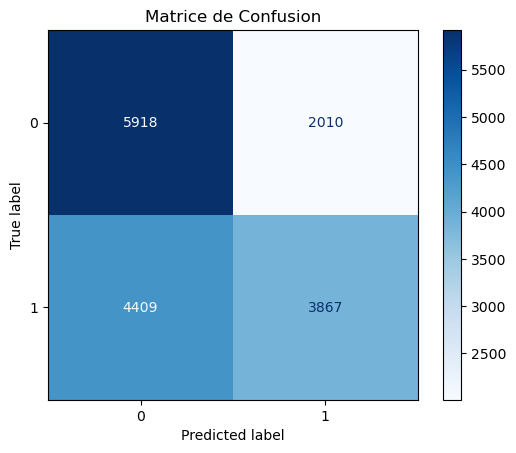

              precision    recall  f1-score   support

           0       0.57      0.75      0.65      7928
           1       0.66      0.47      0.55      8276

    accuracy                           0.60     16204
   macro avg       0.62      0.61      0.60     16204
weighted avg       0.62      0.60      0.60     16204



In [62]:
"""
    L'ajustement (augmentation) du sous échantillonnage (subsample)  

"""



# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0608_v8.joblib'
xgbc_model_v8 = train_and_save_xgboost_classifier_v2(X_train, y_train, best_params_v8, model_path)

# Prédiction et évaluation
evaluation_report = predict_and_evaluate_v2(xgbc_model_v8, X_test, y_test)
print(evaluation_report)

 99%|===================| 16050/16204 [01:34<00:00]        

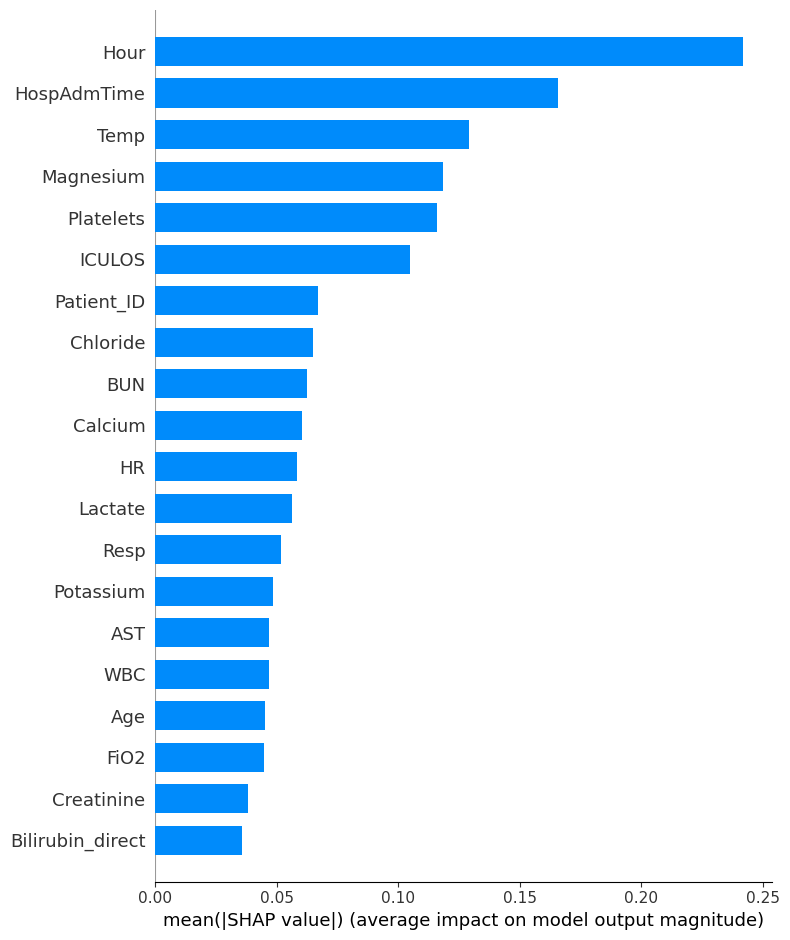

In [63]:
# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model_v8, X_train, X_test)

Tuning de gamma

In [64]:
def objective_v9(trial, X, y, cv=7):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10), 
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.1, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9)
    }
    clf = create_xgb_classifier(params)
    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    return np.mean(score)

# Calcule des meilleurs hyperparamètres
best_params_v9, study = perform_hyperparameter_optimization(X_train, y_train, objective_v9, n_trials=100)
print("Meilleurs hyperparamètres:", best_params_v9)
study_filename = 'optuna_study_0608_v9.pkl'
save_study(study, study_filename)

[I 2024-08-07 03:23:49,704] A new study created in memory with name: no-name-7649ab52-433e-44ae-819a-25d817b5e8be
[I 2024-08-07 03:24:34,105] Trial 0 finished with value: 0.1900774278541366 and parameters: {'learning_rate': 0.03807947176588889, 'max_depth': 10, 'n_estimators': 393, 'min_child_weight': 6, 'gamma': 0.24041677639819287, 'subsample': 0.562397808134481}. Best is trial 0 with value: 0.1900774278541366.
[I 2024-08-07 03:25:26,340] Trial 1 finished with value: 0.1364711993400611 and parameters: {'learning_rate': 0.006750277604651747, 'max_depth': 9, 'n_estimators': 341, 'min_child_weight': 8, 'gamma': 0.1185260448662222, 'subsample': 0.8879639408647977}. Best is trial 0 with value: 0.1900774278541366.
[I 2024-08-07 03:25:34,902] Trial 2 finished with value: 0.12630287423699968 and parameters: {'learning_rate': 0.08341182143924175, 'max_depth': 4, 'n_estimators': 172, 'min_child_weight': 2, 'gamma': 0.373818018663584, 'subsample': 0.7099025726528951}. Best is trial 0 with value

[I 2024-08-07 03:39:30,295] Trial 27 finished with value: 0.2185701350261242 and parameters: {'learning_rate': 0.08672332676123068, 'max_depth': 9, 'n_estimators': 354, 'min_child_weight': 3, 'gamma': 0.4434844704380323, 'subsample': 0.6038797773190965}. Best is trial 26 with value: 0.2230768249785688.
[I 2024-08-07 03:40:11,391] Trial 28 finished with value: 0.21184210164434855 and parameters: {'learning_rate': 0.0844032162696116, 'max_depth': 9, 'n_estimators': 321, 'min_child_weight': 3, 'gamma': 0.4456837007387396, 'subsample': 0.6671215975666988}. Best is trial 26 with value: 0.2230768249785688.
[I 2024-08-07 03:41:24,237] Trial 29 finished with value: 0.1861500995295016 and parameters: {'learning_rate': 0.03236668591450469, 'max_depth': 10, 'n_estimators': 374, 'min_child_weight': 2, 'gamma': 0.2867893878410603, 'subsample': 0.7517196945705387}. Best is trial 26 with value: 0.2230768249785688.
[I 2024-08-07 03:42:13,296] Trial 30 finished with value: 0.20948916879679774 and param

[I 2024-08-07 04:05:21,789] Trial 54 finished with value: 0.13188980064862374 and parameters: {'learning_rate': 0.08207013486314296, 'max_depth': 3, 'n_estimators': 479, 'min_child_weight': 2, 'gamma': 0.47335698802587156, 'subsample': 0.7037350185064587}. Best is trial 37 with value: 0.24825131130721942.
[I 2024-08-07 04:06:19,888] Trial 55 finished with value: 0.2328608970306021 and parameters: {'learning_rate': 0.08104990648349071, 'max_depth': 10, 'n_estimators': 487, 'min_child_weight': 2, 'gamma': 0.6489173820272178, 'subsample': 0.6800539249455313}. Best is trial 37 with value: 0.24825131130721942.
[I 2024-08-07 04:07:17,200] Trial 56 finished with value: 0.2299257630919202 and parameters: {'learning_rate': 0.07336284413073725, 'max_depth': 10, 'n_estimators': 480, 'min_child_weight': 9, 'gamma': 0.5002773417123497, 'subsample': 0.6890963600657248}. Best is trial 37 with value: 0.24825131130721942.
[I 2024-08-07 04:08:24,637] Trial 57 finished with value: 0.22754596788973686 and

[I 2024-08-07 04:31:15,939] Trial 81 finished with value: 0.23681470636405363 and parameters: {'learning_rate': 0.09738312912774025, 'max_depth': 9, 'n_estimators': 491, 'min_child_weight': 4, 'gamma': 0.8002164301680544, 'subsample': 0.5320711948610866}. Best is trial 75 with value: 0.2559116021109547.
[I 2024-08-07 04:32:18,071] Trial 82 finished with value: 0.23928780458229487 and parameters: {'learning_rate': 0.09360061270241146, 'max_depth': 9, 'n_estimators': 471, 'min_child_weight': 3, 'gamma': 0.9621523328570214, 'subsample': 0.5183294270595751}. Best is trial 75 with value: 0.2559116021109547.
[I 2024-08-07 04:33:23,460] Trial 83 finished with value: 0.24795094665257716 and parameters: {'learning_rate': 0.09730489701826234, 'max_depth': 9, 'n_estimators': 500, 'min_child_weight': 3, 'gamma': 0.8366358725855688, 'subsample': 0.5085968157246247}. Best is trial 75 with value: 0.2559116021109547.
[I 2024-08-07 04:34:19,957] Trial 84 finished with value: 0.23986780900172675 and par

Meilleurs hyperparamètres: {'learning_rate': 0.097904480386847, 'max_depth': 9, 'n_estimators': 468, 'min_child_weight': 3, 'gamma': 0.8514902722279756, 'subsample': 0.515073362124163}


[0]	validation_0-logloss:0.68550


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.67798
[2]	validation_0-logloss:0.67175
[3]	validation_0-logloss:0.66711
[4]	validation_0-logloss:0.66328
[5]	validation_0-logloss:0.65996
[6]	validation_0-logloss:0.65665
[7]	validation_0-logloss:0.65528
[8]	validation_0-logloss:0.65401
[9]	validation_0-logloss:0.65234
[10]	validation_0-logloss:0.65060
[11]	validation_0-logloss:0.64969
[12]	validation_0-logloss:0.64833
[13]	validation_0-logloss:0.64644
[14]	validation_0-logloss:0.64364
[15]	validation_0-logloss:0.64280
[16]	validation_0-logloss:0.64184
[17]	validation_0-logloss:0.64149
[18]	validation_0-logloss:0.64021
[19]	validation_0-logloss:0.63828
[20]	validation_0-logloss:0.63787
[21]	validation_0-logloss:0.63641
[22]	validation_0-logloss:0.63407
[23]	validation_0-logloss:0.63468
[24]	validation_0-logloss:0.63408
[25]	validation_0-logloss:0.63378
[26]	validation_0-logloss:0.63354
[27]	validation_0-logloss:0.63171
[28]	validation_0-logloss:0.63256
[29]	validation_0-logloss:0.63273
[30]	validation_0-loglo

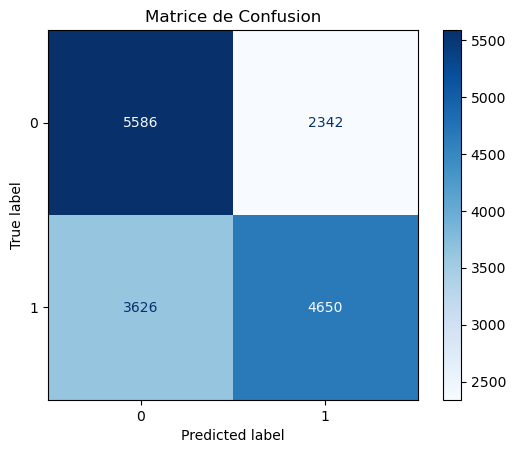

              precision    recall  f1-score   support

           0       0.61      0.70      0.65      7928
           1       0.67      0.56      0.61      8276

    accuracy                           0.63     16204
   macro avg       0.64      0.63      0.63     16204
weighted avg       0.64      0.63      0.63     16204



In [65]:
"""
    L'ajustement (augmentation) du sous échantillonnage (subsample)  

"""



# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0608_v9.joblib'
xgbc_model_v9 = train_and_save_xgboost_classifier_v2(X_train, y_train, best_params_v9, model_path)

# Prédiction et évaluation
evaluation_report = predict_and_evaluate_v2(xgbc_model_v9, X_test, y_test)
print(evaluation_report)

 98%|===================| 15937/16204 [00:57<00:00]        

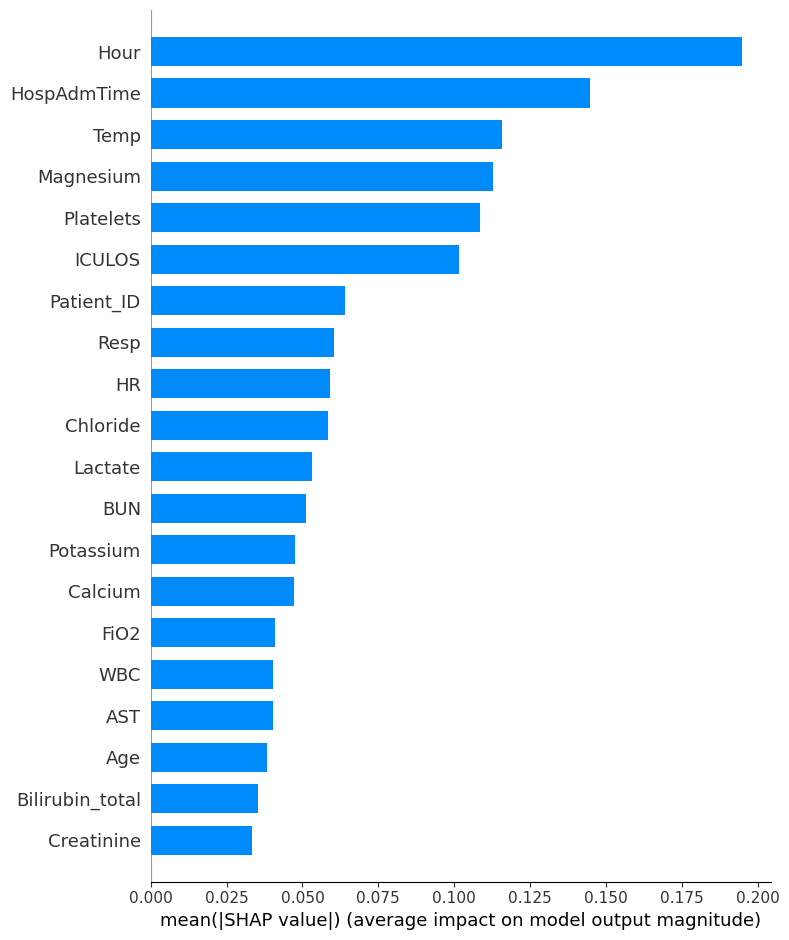

In [66]:
# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model_v9, X_train, X_test)

Augmentation de min_child_weight

[I 2024-08-07 04:52:52,050] A new study created in memory with name: no-name-3e254a36-2b41-4ade-9020-d81525ede8c2
[I 2024-08-07 04:53:25,517] Trial 0 finished with value: 0.18102608044007915 and parameters: {'learning_rate': 0.03807947176588889, 'max_depth': 10, 'n_estimators': 393, 'min_child_weight': 12, 'gamma': 0.24041677639819287, 'subsample': 0.562397808134481}. Best is trial 0 with value: 0.18102608044007915.
[I 2024-08-07 04:54:10,389] Trial 1 finished with value: 0.13684546257742997 and parameters: {'learning_rate': 0.006750277604651747, 'max_depth': 9, 'n_estimators': 341, 'min_child_weight': 15, 'gamma': 0.1185260448662222, 'subsample': 0.8879639408647977}. Best is trial 0 with value: 0.18102608044007915.
[I 2024-08-07 04:54:19,035] Trial 2 finished with value: 0.12803444770800784 and parameters: {'learning_rate': 0.08341182143924175, 'max_depth': 4, 'n_estimators': 172, 'min_child_weight': 4, 'gamma': 0.373818018663584, 'subsample': 0.7099025726528951}. Best is trial 0 with

[I 2024-08-07 05:06:47,174] Trial 27 finished with value: 0.2125219822994979 and parameters: {'learning_rate': 0.08425645355558427, 'max_depth': 9, 'n_estimators': 345, 'min_child_weight': 3, 'gamma': 0.8946276872431751, 'subsample': 0.6739981407261354}. Best is trial 25 with value: 0.22489941477953332.
[I 2024-08-07 05:07:51,129] Trial 28 finished with value: 0.1618032859244473 and parameters: {'learning_rate': 0.019662943724230074, 'max_depth': 9, 'n_estimators': 447, 'min_child_weight': 2, 'gamma': 0.9861328653352055, 'subsample': 0.6743101231804098}. Best is trial 25 with value: 0.22489941477953332.
[I 2024-08-07 05:08:42,866] Trial 29 finished with value: 0.21923868854753886 and parameters: {'learning_rate': 0.06484896671636527, 'max_depth': 10, 'n_estimators': 420, 'min_child_weight': 5, 'gamma': 0.9006007775194949, 'subsample': 0.6094289115145795}. Best is trial 25 with value: 0.22489941477953332.
[I 2024-08-07 05:09:33,395] Trial 30 finished with value: 0.21515997925698746 and 

[I 2024-08-07 05:27:30,189] Trial 54 finished with value: 0.23033731000809235 and parameters: {'learning_rate': 0.08196162250139205, 'max_depth': 10, 'n_estimators': 359, 'min_child_weight': 7, 'gamma': 0.43154971468654596, 'subsample': 0.6922200394618455}. Best is trial 53 with value: 0.2330598498463396.
[I 2024-08-07 05:28:13,477] Trial 55 finished with value: 0.21757066239865755 and parameters: {'learning_rate': 0.0780478776089529, 'max_depth': 10, 'n_estimators': 357, 'min_child_weight': 7, 'gamma': 0.4088937565674654, 'subsample': 0.7063607314469981}. Best is trial 53 with value: 0.2330598498463396.
[I 2024-08-07 05:28:49,446] Trial 56 finished with value: 0.22075697462258356 and parameters: {'learning_rate': 0.0955322602689961, 'max_depth': 10, 'n_estimators': 308, 'min_child_weight': 9, 'gamma': 0.29723745943355884, 'subsample': 0.6802867693596809}. Best is trial 53 with value: 0.2330598498463396.
[I 2024-08-07 05:29:25,794] Trial 57 finished with value: 0.20688478744868027 and 

[I 2024-08-07 05:44:34,867] Trial 81 finished with value: 0.2316721255707252 and parameters: {'learning_rate': 0.09038480698891835, 'max_depth': 10, 'n_estimators': 406, 'min_child_weight': 6, 'gamma': 0.36058290587146025, 'subsample': 0.7200875416077149}. Best is trial 62 with value: 0.2338729282637741.
[I 2024-08-07 05:45:25,298] Trial 82 finished with value: 0.23542589473302003 and parameters: {'learning_rate': 0.09215527200146836, 'max_depth': 10, 'n_estimators': 431, 'min_child_weight': 6, 'gamma': 0.3252517533282693, 'subsample': 0.7128161295169259}. Best is trial 82 with value: 0.23542589473302003.
[I 2024-08-07 05:46:16,109] Trial 83 finished with value: 0.24187247313191754 and parameters: {'learning_rate': 0.09141716504556013, 'max_depth': 10, 'n_estimators': 433, 'min_child_weight': 6, 'gamma': 0.3116097956004712, 'subsample': 0.7506502117211309}. Best is trial 83 with value: 0.24187247313191754.
[I 2024-08-07 05:47:06,871] Trial 84 finished with value: 0.24065087210187097 an

Meilleurs hyperparamètres: {'learning_rate': 0.09223266910594016, 'max_depth': 10, 'n_estimators': 474, 'min_child_weight': 6, 'gamma': 0.24302939004884552, 'subsample': 0.7462148762830613}
[0]	validation_0-logloss:0.68582
[1]	validation_0-logloss:0.68043
[2]	validation_0-logloss:0.67678
[3]	validation_0-logloss:0.67196
[4]	validation_0-logloss:0.66933
[5]	validation_0-logloss:0.66580
[6]	validation_0-logloss:0.66179
[7]	validation_0-logloss:0.65880
[8]	validation_0-logloss:0.65767
[9]	validation_0-logloss:0.65658
[10]	validation_0-logloss:0.65563
[11]	validation_0-logloss:0.65567
[12]	validation_0-logloss:0.65457
[13]	validation_0-logloss:0.65456
[14]	validation_0-logloss:0.65382
[15]	validation_0-logloss:0.65323
[16]	validation_0-logloss:0.65278
[17]	validation_0-logloss:0.65189
[18]	validation_0-logloss:0.65060
[19]	validation_0-logloss:0.64890
[20]	validation_0-logloss:0.64868
[21]	validation_0-logloss:0.64853
[22]	validation_0-logloss:0.64573
[23]	validation_0-logloss:0.64568
[24]

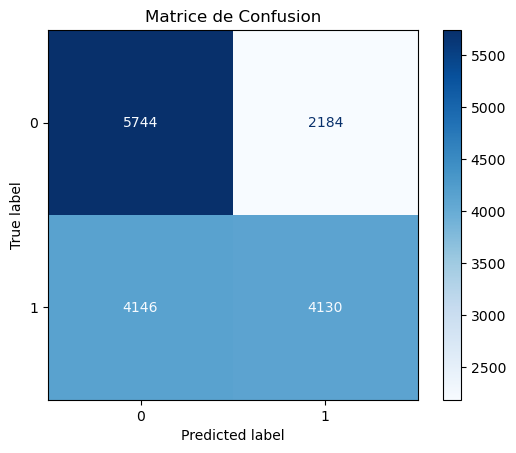

              precision    recall  f1-score   support

           0       0.58      0.72      0.64      7928
           1       0.65      0.50      0.57      8276

    accuracy                           0.61     16204
   macro avg       0.62      0.61      0.61     16204
weighted avg       0.62      0.61      0.60     16204



100%|===================| 16173/16204 [01:18<00:00]        

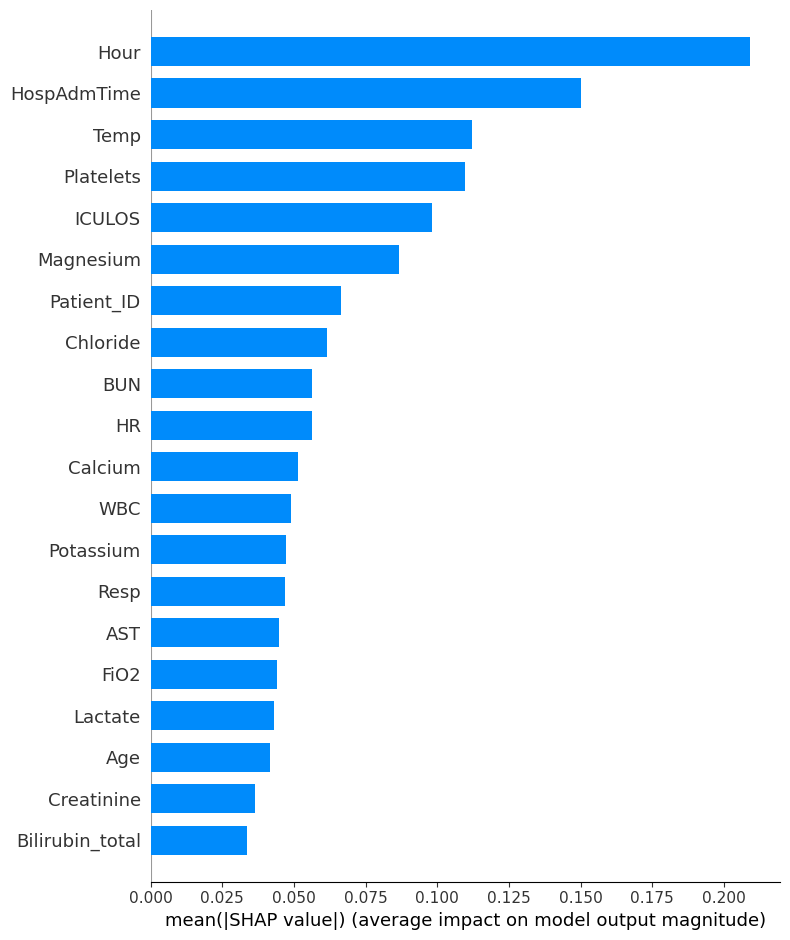

In [67]:
"""
     

"""




def objective_v10(trial, X, y, cv=7):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10), 
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20), 
        'gamma': trial.suggest_float('gamma', 0.1, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9)
    }
    clf = create_xgb_classifier(params)
    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    return np.mean(score)



# Calcule des meilleurs hyperparamètres
best_params_v10, study = perform_hyperparameter_optimization(X_train, y_train, objective_v10, n_trials=100)
print("Meilleurs hyperparamètres:", best_params_v10)
study_filename = 'optuna_study_0608_v10.pkl'
save_study(study, study_filename)



# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0608_v10.joblib'
xgbc_model_v10 = train_and_save_xgboost_classifier_v2(X_train, y_train, best_params_v10, model_path)

# Prédiction et évaluation
evaluation_report = predict_and_evaluate_v2(xgbc_model_v10, X_test, y_test)
print(evaluation_report)

# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model_v10, X_train, X_test)

[I 2024-08-07 10:02:39,893] A new study created in memory with name: no-name-3bd6656f-6d46-418d-9f55-0ea58b15490a
[I 2024-08-07 10:03:42,476] Trial 0 finished with value: 0.18102608044007915 and parameters: {'learning_rate': 0.03807947176588889, 'max_depth': 10, 'n_estimators': 393, 'min_child_weight': 12, 'gamma': 0.24041677639819287, 'subsample': 0.562397808134481}. Best is trial 0 with value: 0.18102608044007915.
[I 2024-08-07 10:04:45,370] Trial 1 finished with value: 0.13684546257742997 and parameters: {'learning_rate': 0.006750277604651747, 'max_depth': 9, 'n_estimators': 341, 'min_child_weight': 15, 'gamma': 0.1185260448662222, 'subsample': 0.8879639408647977}. Best is trial 0 with value: 0.18102608044007915.
[I 2024-08-07 10:04:57,235] Trial 2 finished with value: 0.12803444770800784 and parameters: {'learning_rate': 0.08341182143924175, 'max_depth': 4, 'n_estimators': 172, 'min_child_weight': 4, 'gamma': 0.373818018663584, 'subsample': 0.7099025726528951}. Best is trial 0 with

[I 2024-08-07 10:22:15,751] Trial 27 finished with value: 0.2125219822994979 and parameters: {'learning_rate': 0.08425645355558427, 'max_depth': 9, 'n_estimators': 345, 'min_child_weight': 3, 'gamma': 0.8946276872431751, 'subsample': 0.6739981407261354}. Best is trial 25 with value: 0.22489941477953332.
[I 2024-08-07 10:23:41,411] Trial 28 finished with value: 0.1618032859244473 and parameters: {'learning_rate': 0.019662943724230074, 'max_depth': 9, 'n_estimators': 447, 'min_child_weight': 2, 'gamma': 0.9861328653352055, 'subsample': 0.6743101231804098}. Best is trial 25 with value: 0.22489941477953332.
[I 2024-08-07 10:24:51,216] Trial 29 finished with value: 0.21923868854753886 and parameters: {'learning_rate': 0.06484896671636527, 'max_depth': 10, 'n_estimators': 420, 'min_child_weight': 5, 'gamma': 0.9006007775194949, 'subsample': 0.6094289115145795}. Best is trial 25 with value: 0.22489941477953332.
[I 2024-08-07 10:25:59,104] Trial 30 finished with value: 0.21515997925698746 and 

[I 2024-08-07 10:50:38,446] Trial 54 finished with value: 0.23033731000809235 and parameters: {'learning_rate': 0.08196162250139205, 'max_depth': 10, 'n_estimators': 359, 'min_child_weight': 7, 'gamma': 0.43154971468654596, 'subsample': 0.6922200394618455}. Best is trial 53 with value: 0.2330598498463396.
[I 2024-08-07 10:51:39,829] Trial 55 finished with value: 0.21757066239865755 and parameters: {'learning_rate': 0.0780478776089529, 'max_depth': 10, 'n_estimators': 357, 'min_child_weight': 7, 'gamma': 0.4088937565674654, 'subsample': 0.7063607314469981}. Best is trial 53 with value: 0.2330598498463396.
[I 2024-08-07 10:52:28,985] Trial 56 finished with value: 0.22075697462258356 and parameters: {'learning_rate': 0.0955322602689961, 'max_depth': 10, 'n_estimators': 308, 'min_child_weight': 9, 'gamma': 0.29723745943355884, 'subsample': 0.6802867693596809}. Best is trial 53 with value: 0.2330598498463396.
[I 2024-08-07 10:53:18,581] Trial 57 finished with value: 0.20688478744868027 and 

[I 2024-08-07 11:14:40,469] Trial 81 finished with value: 0.2316721255707252 and parameters: {'learning_rate': 0.09038480698891835, 'max_depth': 10, 'n_estimators': 406, 'min_child_weight': 6, 'gamma': 0.36058290587146025, 'subsample': 0.7200875416077149}. Best is trial 62 with value: 0.2338729282637741.
[I 2024-08-07 11:15:53,703] Trial 82 finished with value: 0.23542589473302003 and parameters: {'learning_rate': 0.09215527200146836, 'max_depth': 10, 'n_estimators': 431, 'min_child_weight': 6, 'gamma': 0.3252517533282693, 'subsample': 0.7128161295169259}. Best is trial 82 with value: 0.23542589473302003.
[I 2024-08-07 11:17:05,966] Trial 83 finished with value: 0.24187247313191754 and parameters: {'learning_rate': 0.09141716504556013, 'max_depth': 10, 'n_estimators': 433, 'min_child_weight': 6, 'gamma': 0.3116097956004712, 'subsample': 0.7506502117211309}. Best is trial 83 with value: 0.24187247313191754.
[I 2024-08-07 11:18:17,199] Trial 84 finished with value: 0.24065087210187097 an

Meilleurs hyperparamètres: {'learning_rate': 0.09223266910594016, 'max_depth': 10, 'n_estimators': 474, 'min_child_weight': 6, 'gamma': 0.24302939004884552, 'subsample': 0.7462148762830613}
[0]	validation_0-logloss:0.68582
[1]	validation_0-logloss:0.68043
[2]	validation_0-logloss:0.67678
[3]	validation_0-logloss:0.67196
[4]	validation_0-logloss:0.66933
[5]	validation_0-logloss:0.66580
[6]	validation_0-logloss:0.66179
[7]	validation_0-logloss:0.65880
[8]	validation_0-logloss:0.65767
[9]	validation_0-logloss:0.65658
[10]	validation_0-logloss:0.65563
[11]	validation_0-logloss:0.65567
[12]	validation_0-logloss:0.65457
[13]	validation_0-logloss:0.65456
[14]	validation_0-logloss:0.65382
[15]	validation_0-logloss:0.65323
[16]	validation_0-logloss:0.65278
[17]	validation_0-logloss:0.65189
[18]	validation_0-logloss:0.65060
[19]	validation_0-logloss:0.64890
[20]	validation_0-logloss:0.64868
[21]	validation_0-logloss:0.64853
[22]	validation_0-logloss:0.64573
[23]	validation_0-logloss:0.64568
[24]

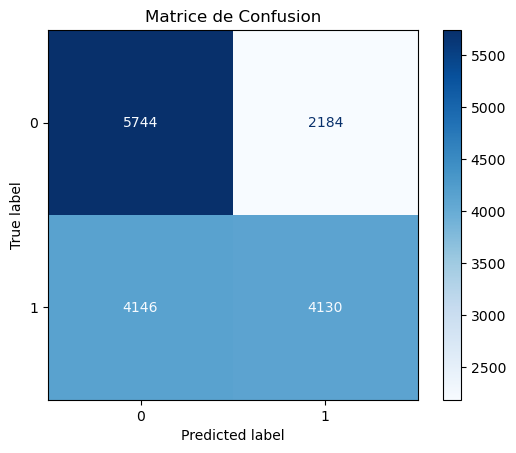

              precision    recall  f1-score   support

           0       0.58      0.72      0.64      7928
           1       0.65      0.50      0.57      8276

    accuracy                           0.61     16204
   macro avg       0.62      0.61      0.61     16204
weighted avg       0.62      0.61      0.60     16204



 99%|===================| 16122/16204 [02:31<00:00]        

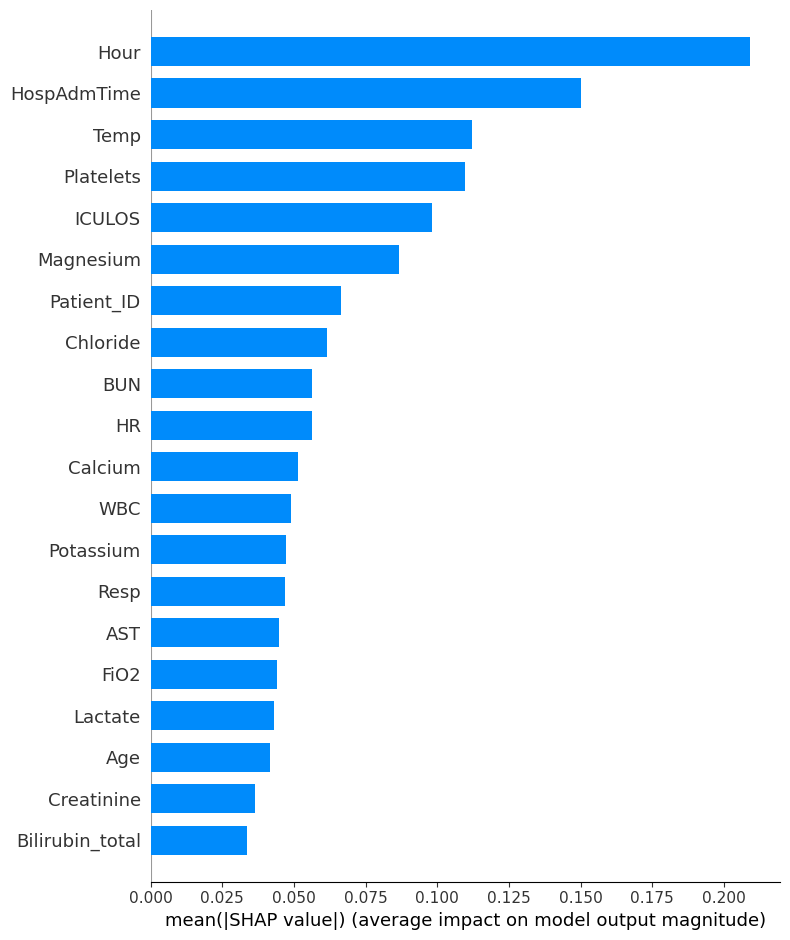

In [69]:
"""
    augmentation de l'arrêt prématuré de 10 à 50 n'affecte pas les performances

"""




def objective_v10(trial, X, y, cv=7):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10), 
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20), 
        'gamma': trial.suggest_float('gamma', 0.1, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9)
    }
    clf = create_xgb_classifier(params)
    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    return np.mean(score)



# Calcule des meilleurs hyperparamètres
best_params_v10, study = perform_hyperparameter_optimization(X_train, y_train, objective_v10, n_trials=100)
print("Meilleurs hyperparamètres:", best_params_v10)
study_filename = 'optuna_study_0608_v10.pkl'
save_study(study, study_filename)



# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0608_v10.joblib'
xgbc_model_v10 = train_and_save_xgboost_classifier_v2(X_train, y_train, best_params_v10, model_path)

# Prédiction et évaluation
evaluation_report = predict_and_evaluate_v2(xgbc_model_v10, X_test, y_test)
print(evaluation_report)

# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model_v10, X_train, X_test)

# Ajout de la colonne SIRS_score 

In [71]:
df = balanced_data.copy()
df

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel_Previous
9217,1069,27.94,1,-0.02,11,9,87.0,98.0,36.500,98.0,...,4.400000,0.2,23.20,34.600000,12.500000,25.200000,10.800000,451.0,143.000000,0
155037,19099,81.99,1,-0.03,56,52,88.0,95.0,38.100,107.0,...,3.900000,0.7,4.80,24.000000,9.700000,25.400000,11.300000,450.0,108.000000,0
134696,16629,71.78,1,-0.03,17,15,69.0,100.0,37.044,148.0,...,4.645455,0.6,0.80,29.090909,9.872727,28.427273,10.081818,724.0,212.272727,0
88583,10958,69.38,1,-165.09,30,25,78.0,93.0,36.688,106.0,...,4.581818,0.3,24.30,26.327273,9.109091,39.057143,9.463636,255.0,188.521739,0
114725,14259,67.25,0,-0.02,16,15,86.0,100.0,36.695,131.0,...,3.458333,0.5,2.60,37.325000,12.316667,52.800000,19.816667,269.0,208.916667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245826,119959,56.00,0,-321.03,37,36,91.0,96.0,37.000,127.0,...,4.000000,0.9,0.04,28.000000,8.200000,31.500000,11.500000,290.0,286.000000,1
245827,119959,56.00,0,-321.03,38,37,91.0,95.0,36.700,151.0,...,4.000000,0.9,0.04,28.000000,8.200000,31.500000,11.500000,290.0,286.000000,1
245828,119959,56.00,0,-321.03,39,38,95.0,94.0,36.600,150.0,...,4.000000,0.9,0.04,28.000000,8.200000,31.500000,11.500000,290.0,286.000000,1
245829,119959,56.00,0,-321.03,40,39,91.0,95.0,36.700,131.0,...,4.000000,0.9,0.04,28.000000,8.200000,31.500000,11.500000,290.0,286.000000,1


In [76]:
df.columns

Index(['Patient_ID', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'Hour', 'HR',
       'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess',
       'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
       'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
       'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets',
       'SepsisLabel_Previous'],
      dtype='object')

In [77]:
condition_temp=(df['Temp']>38) |( df['Temp']<36)
condition_HR=(df['HR']>90)
condition_Resp=(df['Resp']>20) |( df['PaCO2']<32)
condition_wbc=(df['WBC']>12000) |( df['WBC']<4000)


df['SIRS_Score']=np.where(condition_temp, 1, 0)+np.where(condition_HR, 1, 0)+np.where(condition_Resp, 1, 0)+np.where(condition_wbc, 1, 0)

In [78]:
df

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel_Previous,SIRS_Score
9217,1069,27.94,1,-0.02,11,9,87.0,98.0,36.500,98.0,...,0.2,23.20,34.600000,12.500000,25.200000,10.800000,451.0,143.000000,0,1
155037,19099,81.99,1,-0.03,56,52,88.0,95.0,38.100,107.0,...,0.7,4.80,24.000000,9.700000,25.400000,11.300000,450.0,108.000000,0,3
134696,16629,71.78,1,-0.03,17,15,69.0,100.0,37.044,148.0,...,0.6,0.80,29.090909,9.872727,28.427273,10.081818,724.0,212.272727,0,1
88583,10958,69.38,1,-165.09,30,25,78.0,93.0,36.688,106.0,...,0.3,24.30,26.327273,9.109091,39.057143,9.463636,255.0,188.521739,0,1
114725,14259,67.25,0,-0.02,16,15,86.0,100.0,36.695,131.0,...,0.5,2.60,37.325000,12.316667,52.800000,19.816667,269.0,208.916667,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245826,119959,56.00,0,-321.03,37,36,91.0,96.0,37.000,127.0,...,0.9,0.04,28.000000,8.200000,31.500000,11.500000,290.0,286.000000,1,3
245827,119959,56.00,0,-321.03,38,37,91.0,95.0,36.700,151.0,...,0.9,0.04,28.000000,8.200000,31.500000,11.500000,290.0,286.000000,1,3
245828,119959,56.00,0,-321.03,39,38,95.0,94.0,36.600,150.0,...,0.9,0.04,28.000000,8.200000,31.500000,11.500000,290.0,286.000000,1,3
245829,119959,56.00,0,-321.03,40,39,91.0,95.0,36.700,131.0,...,0.9,0.04,28.000000,8.200000,31.500000,11.500000,290.0,286.000000,1,3


In [84]:
sorted_df = sort_dataframe_by_patient_and_hour(df)

In [85]:
X_train_, y_train_, X_test_, y_test_ = split_train_test_v2(sorted_df, 'SepsisLabel_Previous')
X_train_.shape, y_train_.shape, X_test_.shape, y_test_.shape

((61487, 41), (61487,), (15211, 41), (15211,))

In [86]:
X_train_

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SIRS_Score
14,9,27.92,1,-0.03,15,14,104.0,91.0,36.683333,96.0,...,4.333333,1.5,23.2,39.500000,13.484615,35.222222,9.100000,267.500,129.692308,2
21,9,27.92,1,-0.03,22,21,91.5,97.0,36.940000,113.0,...,4.260000,1.5,23.2,38.772727,14.400000,31.111111,12.554545,292.875,130.818182,2
22,9,27.92,1,-0.03,23,22,91.0,97.0,37.000000,109.0,...,4.140000,1.5,23.2,38.609091,14.300000,31.166667,12.781818,296.500,127.727273,2
23,9,27.92,1,-0.03,24,23,90.0,99.0,37.060000,103.0,...,4.020000,1.5,23.2,38.445455,14.200000,31.222222,13.009091,300.125,124.636364,1
33,9,27.92,1,-0.03,34,33,96.0,99.0,37.500000,130.0,...,4.350000,1.5,23.2,36.137500,12.937500,31.777778,13.212500,336.375,99.250000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245881,119987,75.00,0,-28.15,23,22,64.0,99.0,38.100000,134.0,...,4.293750,1.2,28.4,26.120000,8.380000,57.000000,14.160000,158.000,89.400000,2
245883,119987,75.00,0,-28.15,25,24,67.0,96.5,38.000000,139.0,...,4.247917,1.2,28.4,26.024000,8.356000,57.000000,14.432000,158.000,89.480000,1
245886,119987,75.00,0,-28.15,28,27,63.5,100.0,38.300000,155.0,...,4.179167,1.2,28.4,25.880000,8.320000,57.000000,14.840000,158.000,89.600000,2
245889,119987,75.00,0,-28.15,31,30,64.0,96.0,38.100000,145.0,...,4.110417,1.2,28.4,25.736000,8.284000,57.000000,15.248000,158.000,89.720000,2


[I 2024-08-07 12:28:04,361] A new study created in memory with name: no-name-be8275fc-d50b-4143-82ab-42bac2380403
[I 2024-08-07 12:29:14,387] Trial 0 finished with value: 0.1900774278541366 and parameters: {'learning_rate': 0.03807947176588889, 'max_depth': 10, 'n_estimators': 393, 'min_child_weight': 6, 'gamma': 0.24041677639819287, 'subsample': 0.562397808134481}. Best is trial 0 with value: 0.1900774278541366.
[I 2024-08-07 12:30:22,417] Trial 1 finished with value: 0.1364711993400611 and parameters: {'learning_rate': 0.006750277604651747, 'max_depth': 9, 'n_estimators': 341, 'min_child_weight': 8, 'gamma': 0.1185260448662222, 'subsample': 0.8879639408647977}. Best is trial 0 with value: 0.1900774278541366.
[I 2024-08-07 12:30:34,618] Trial 2 finished with value: 0.12630287423699968 and parameters: {'learning_rate': 0.08341182143924175, 'max_depth': 4, 'n_estimators': 172, 'min_child_weight': 2, 'gamma': 0.373818018663584, 'subsample': 0.7099025726528951}. Best is trial 0 with value

[I 2024-08-07 12:48:20,667] Trial 27 finished with value: 0.2185701350261242 and parameters: {'learning_rate': 0.08672332676123068, 'max_depth': 9, 'n_estimators': 354, 'min_child_weight': 3, 'gamma': 0.4434844704380323, 'subsample': 0.6038797773190965}. Best is trial 26 with value: 0.2230768249785688.
[I 2024-08-07 12:49:14,892] Trial 28 finished with value: 0.21184210164434855 and parameters: {'learning_rate': 0.0844032162696116, 'max_depth': 9, 'n_estimators': 321, 'min_child_weight': 3, 'gamma': 0.4456837007387396, 'subsample': 0.6671215975666988}. Best is trial 26 with value: 0.2230768249785688.
[I 2024-08-07 12:50:47,395] Trial 29 finished with value: 0.1861500995295016 and parameters: {'learning_rate': 0.03236668591450469, 'max_depth': 10, 'n_estimators': 374, 'min_child_weight': 2, 'gamma': 0.2867893878410603, 'subsample': 0.7517196945705387}. Best is trial 26 with value: 0.2230768249785688.
[I 2024-08-07 12:51:47,012] Trial 30 finished with value: 0.20948916879679774 and param

[I 2024-08-07 13:17:48,913] Trial 54 finished with value: 0.13188980064862374 and parameters: {'learning_rate': 0.08207013486314296, 'max_depth': 3, 'n_estimators': 479, 'min_child_weight': 2, 'gamma': 0.47335698802587156, 'subsample': 0.7037350185064587}. Best is trial 37 with value: 0.24825131130721942.
[I 2024-08-07 13:19:04,797] Trial 55 finished with value: 0.2328608970306021 and parameters: {'learning_rate': 0.08104990648349071, 'max_depth': 10, 'n_estimators': 487, 'min_child_weight': 2, 'gamma': 0.6489173820272178, 'subsample': 0.6800539249455313}. Best is trial 37 with value: 0.24825131130721942.
[I 2024-08-07 13:19:58,799] Trial 56 finished with value: 0.2299257630919202 and parameters: {'learning_rate': 0.07336284413073725, 'max_depth': 10, 'n_estimators': 480, 'min_child_weight': 9, 'gamma': 0.5002773417123497, 'subsample': 0.6890963600657248}. Best is trial 37 with value: 0.24825131130721942.
[I 2024-08-07 13:21:01,772] Trial 57 finished with value: 0.22754596788973686 and

[I 2024-08-07 13:40:01,543] Trial 81 finished with value: 0.23681470636405363 and parameters: {'learning_rate': 0.09738312912774025, 'max_depth': 9, 'n_estimators': 491, 'min_child_weight': 4, 'gamma': 0.8002164301680544, 'subsample': 0.5320711948610866}. Best is trial 75 with value: 0.2559116021109547.
[I 2024-08-07 13:40:48,364] Trial 82 finished with value: 0.23928780458229487 and parameters: {'learning_rate': 0.09360061270241146, 'max_depth': 9, 'n_estimators': 471, 'min_child_weight': 3, 'gamma': 0.9621523328570214, 'subsample': 0.5183294270595751}. Best is trial 75 with value: 0.2559116021109547.
[I 2024-08-07 13:41:38,383] Trial 83 finished with value: 0.24795094665257716 and parameters: {'learning_rate': 0.09730489701826234, 'max_depth': 9, 'n_estimators': 500, 'min_child_weight': 3, 'gamma': 0.8366358725855688, 'subsample': 0.5085968157246247}. Best is trial 75 with value: 0.2559116021109547.
[I 2024-08-07 13:42:24,426] Trial 84 finished with value: 0.23986780900172675 and par

Meilleurs hyperparamètres: {'learning_rate': 0.097904480386847, 'max_depth': 9, 'n_estimators': 468, 'min_child_weight': 3, 'gamma': 0.8514902722279756, 'subsample': 0.515073362124163}
[0]	validation_0-logloss:0.68550
[1]	validation_0-logloss:0.67798
[2]	validation_0-logloss:0.67175
[3]	validation_0-logloss:0.66711
[4]	validation_0-logloss:0.66328
[5]	validation_0-logloss:0.65996
[6]	validation_0-logloss:0.65665
[7]	validation_0-logloss:0.65528
[8]	validation_0-logloss:0.65401
[9]	validation_0-logloss:0.65234
[10]	validation_0-logloss:0.65060
[11]	validation_0-logloss:0.64969
[12]	validation_0-logloss:0.64833
[13]	validation_0-logloss:0.64644
[14]	validation_0-logloss:0.64364
[15]	validation_0-logloss:0.64280
[16]	validation_0-logloss:0.64184
[17]	validation_0-logloss:0.64149
[18]	validation_0-logloss:0.64021
[19]	validation_0-logloss:0.63828
[20]	validation_0-logloss:0.63787
[21]	validation_0-logloss:0.63641
[22]	validation_0-logloss:0.63407
[23]	validation_0-logloss:0.63468
[24]	vali

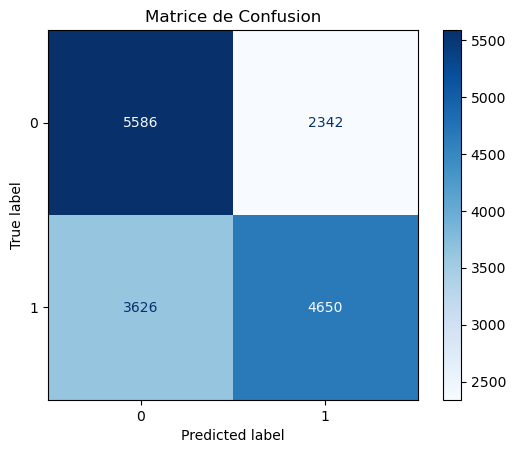

              precision    recall  f1-score   support

           0       0.61      0.70      0.65      7928
           1       0.67      0.56      0.61      8276

    accuracy                           0.63     16204
   macro avg       0.64      0.63      0.63     16204
weighted avg       0.64      0.63      0.63     16204



 99%|===================| 16074/16204 [01:00<00:00]        

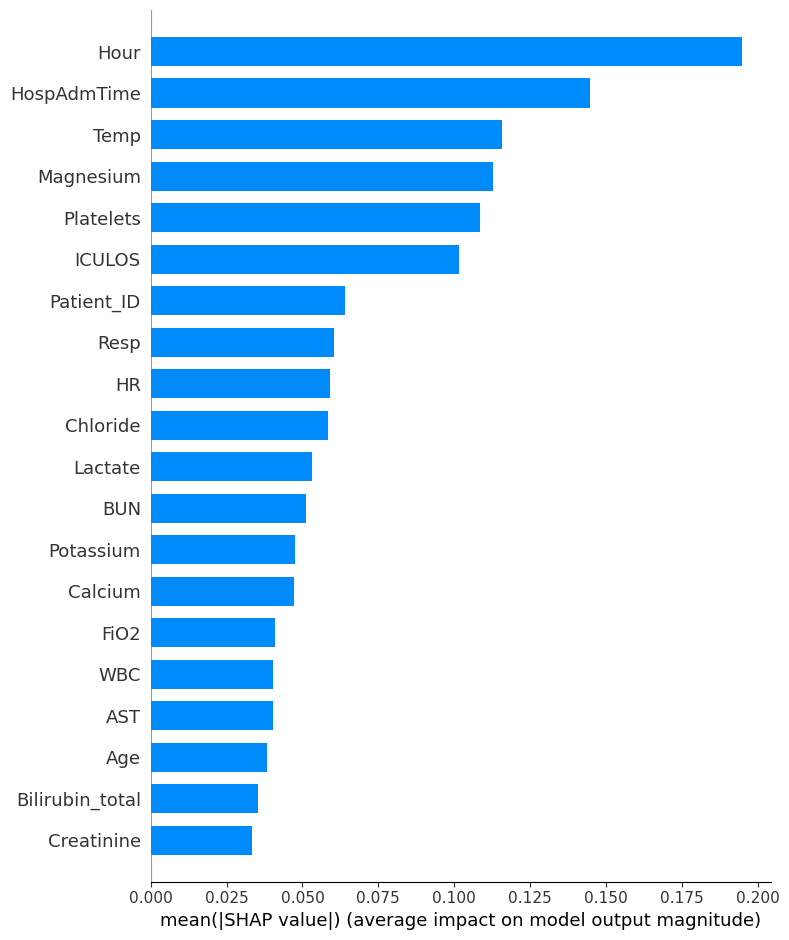

In [87]:
"""
     

"""




def objective_v11(trial, X, y, cv=7):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10), 
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), 
        'gamma': trial.suggest_float('gamma', 0.1, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9)
    }
    clf = create_xgb_classifier(params)
    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    return np.mean(score)



# Calcule des meilleurs hyperparamètres
best_params_v11, study = perform_hyperparameter_optimization(X_train, y_train, objective_v11, n_trials=100)
print("Meilleurs hyperparamètres:", best_params_v11)
study_filename = 'optuna_study_0608_v11.pkl'
save_study(study, study_filename)



# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0608_v11.joblib'
xgbc_model_v11 = train_and_save_xgboost_classifier_v2(X_train, y_train, best_params_v11, model_path)

# Prédiction et évaluation
evaluation_report = predict_and_evaluate_v2(xgbc_model_v11, X_test, y_test)
print(evaluation_report)

# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model_v11, X_train, X_test)

# Ajout de la colonne SOFA_score

In [103]:
import pandas as pd

def calculate_sofa_score(df):
    # Calcul du ratio PaO2/FiO2
#     df['PaO2_FiO2'] = 100 * df['PaO2'] / df['FiO2']

    # Définition des fonctions pour calculer chaque facteur
    def platelets_factor(platelets):
        if platelets < 20:
            return 4
        elif platelets < 50:
            return 3
        elif platelets < 100:
            return 2
        elif platelets < 150:
            return 1
        else:
            return 0

    def bilirubin_factor(bilirubin):
        if bilirubin < 1.2:
            return 0
        elif bilirubin < 2:
            return 1
        elif bilirubin < 6:
            return 2
        elif bilirubin < 12:
            return 3
        else:
            return 4

    def gcs_factor(gcs):
        if gcs > 14:
            return 0
        elif gcs > 12:
            return 1
        elif gcs > 9:
            return 2
        elif gcs > 5:
            return 3
        else:
            return 4

    def pao2_fio2_factor(row):
        if row['PaO2_FiO2'] <= 100:
            return 4
        elif row['PaO2_FiO2'] <= 200:
            return 3
        elif row['PaO2_FiO2'] <= 300:
            return 2
        elif row['PaO2_FiO2'] <= 400:
            return 1
        else:
            return 0

    def renal_factor(row):
        if row['Creatinine'] < 1.2:
            return 0
        elif row['Creatinine'] < 2:
            return 1
        elif row['Creatinine'] < 3.5:
            return 2
        elif row['Creatinine'] < 5:
            return 3
        else:
            return 4
        if row['Urine_Output'] < 200:
            return 4
        elif row['Urine_Output'] < 500:
            return 3
        else:
            return max(0, row['Creatinine_Factor'])

    # Application des fonctions de calcul des facteurs
    df['Plaquettes_Factor'] = df['Platelets'].apply(platelets_factor)
    df['Bilirubine_Factor'] = df['Bilirubin_total'].apply(bilirubin_factor)
#     df['GCS_Factor'] = df['Score_Comma_Glasgow'].apply(gcs_factor)
#     df['PaO2_FiO2_Factor'] = df.apply(pao2_fio2_factor, axis=1)
    df['Creatinine_Factor'] = df.apply(renal_factor, axis=1)

    # Calcul du score SOFA total
#     df['SOFA_score'] = df[['Plaquettes_Factor', 'Bilirubine_Factor', 'GCS_Factor', 'PaO2_FiO2_Factor', 'Creatinine_Factor']].sum(axis=1)
    df['SOFA_score'] = df[['Plaquettes_Factor', 'Bilirubine_Factor', 'Creatinine_Factor']].sum(axis=1)
    df.drop(columns=['Plaquettes_Factor', 'Bilirubine_Factor','Creatinine_Factor'], inplace=True)
    return df

# Appliquez la fonction sur votre DataFrame
with_sofa_sorted_df = calculate_sofa_score(sorted_df)


In [104]:
with_sofa_sorted_df

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel_Previous,SIRS_Score,SOFA_score
14,9,27.92,1,-0.03,15,14,104.0,91.0,36.683333,96.0,...,23.2,39.500000,13.484615,35.222222,9.100000,267.500,129.692308,0,2,2
21,9,27.92,1,-0.03,22,21,91.5,97.0,36.940000,113.0,...,23.2,38.772727,14.400000,31.111111,12.554545,292.875,130.818182,0,2,3
22,9,27.92,1,-0.03,23,22,91.0,97.0,37.000000,109.0,...,23.2,38.609091,14.300000,31.166667,12.781818,296.500,127.727273,0,2,3
23,9,27.92,1,-0.03,24,23,90.0,99.0,37.060000,103.0,...,23.2,38.445455,14.200000,31.222222,13.009091,300.125,124.636364,0,1,3
33,9,27.92,1,-0.03,34,33,96.0,99.0,37.500000,130.0,...,23.2,36.137500,12.937500,31.777778,13.212500,336.375,99.250000,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245901,119994,71.00,1,-29.57,4,3,82.0,99.0,36.500000,106.0,...,28.4,25.400000,8.200000,57.000000,16.200000,158.000,90.000000,0,1,3
245902,119994,71.00,1,-29.57,5,4,82.0,99.0,37.000000,141.0,...,28.4,25.400000,8.200000,57.000000,16.200000,158.000,90.000000,0,1,3
245909,119994,71.00,1,-29.57,12,11,76.0,100.0,37.800000,122.0,...,28.4,30.300000,10.291304,57.000000,7.565217,158.000,70.217391,0,1,3
245920,119994,71.00,1,-29.57,23,22,74.0,95.0,37.600000,122.0,...,28.4,30.300000,10.243478,57.000000,9.573913,158.000,65.913043,0,2,3


[I 2024-08-07 15:50:47,360] A new study created in memory with name: no-name-ec00985e-4062-4b8a-a185-9230d30b343f
[I 2024-08-07 15:51:28,903] Trial 0 finished with value: 0.1900774278541366 and parameters: {'learning_rate': 0.03807947176588889, 'max_depth': 10, 'n_estimators': 393, 'min_child_weight': 6, 'gamma': 0.24041677639819287, 'subsample': 0.562397808134481}. Best is trial 0 with value: 0.1900774278541366.
[I 2024-08-07 15:52:15,293] Trial 1 finished with value: 0.1364711993400611 and parameters: {'learning_rate': 0.006750277604651747, 'max_depth': 9, 'n_estimators': 341, 'min_child_weight': 8, 'gamma': 0.1185260448662222, 'subsample': 0.8879639408647977}. Best is trial 0 with value: 0.1900774278541366.
[I 2024-08-07 15:52:24,515] Trial 2 finished with value: 0.12630287423699968 and parameters: {'learning_rate': 0.08341182143924175, 'max_depth': 4, 'n_estimators': 172, 'min_child_weight': 2, 'gamma': 0.373818018663584, 'subsample': 0.7099025726528951}. Best is trial 0 with value

[I 2024-08-07 16:05:11,418] Trial 27 finished with value: 0.2185701350261242 and parameters: {'learning_rate': 0.08672332676123068, 'max_depth': 9, 'n_estimators': 354, 'min_child_weight': 3, 'gamma': 0.4434844704380323, 'subsample': 0.6038797773190965}. Best is trial 26 with value: 0.2230768249785688.
[I 2024-08-07 16:05:51,125] Trial 28 finished with value: 0.21184210164434855 and parameters: {'learning_rate': 0.0844032162696116, 'max_depth': 9, 'n_estimators': 321, 'min_child_weight': 3, 'gamma': 0.4456837007387396, 'subsample': 0.6671215975666988}. Best is trial 26 with value: 0.2230768249785688.
[I 2024-08-07 16:06:58,273] Trial 29 finished with value: 0.1861500995295016 and parameters: {'learning_rate': 0.03236668591450469, 'max_depth': 10, 'n_estimators': 374, 'min_child_weight': 2, 'gamma': 0.2867893878410603, 'subsample': 0.7517196945705387}. Best is trial 26 with value: 0.2230768249785688.
[I 2024-08-07 16:07:42,405] Trial 30 finished with value: 0.20948916879679774 and param

[I 2024-08-07 16:30:30,523] Trial 54 finished with value: 0.13188980064862374 and parameters: {'learning_rate': 0.08207013486314296, 'max_depth': 3, 'n_estimators': 479, 'min_child_weight': 2, 'gamma': 0.47335698802587156, 'subsample': 0.7037350185064587}. Best is trial 37 with value: 0.24825131130721942.
[I 2024-08-07 16:31:44,174] Trial 55 finished with value: 0.2328608970306021 and parameters: {'learning_rate': 0.08104990648349071, 'max_depth': 10, 'n_estimators': 487, 'min_child_weight': 2, 'gamma': 0.6489173820272178, 'subsample': 0.6800539249455313}. Best is trial 37 with value: 0.24825131130721942.
[I 2024-08-07 16:32:57,069] Trial 56 finished with value: 0.2299257630919202 and parameters: {'learning_rate': 0.07336284413073725, 'max_depth': 10, 'n_estimators': 480, 'min_child_weight': 9, 'gamma': 0.5002773417123497, 'subsample': 0.6890963600657248}. Best is trial 37 with value: 0.24825131130721942.
[I 2024-08-07 16:34:15,665] Trial 57 finished with value: 0.22754596788973686 and

[I 2024-08-07 16:59:56,227] Trial 81 finished with value: 0.23681470636405363 and parameters: {'learning_rate': 0.09738312912774025, 'max_depth': 9, 'n_estimators': 491, 'min_child_weight': 4, 'gamma': 0.8002164301680544, 'subsample': 0.5320711948610866}. Best is trial 75 with value: 0.2559116021109547.
[I 2024-08-07 17:01:05,168] Trial 82 finished with value: 0.23928780458229487 and parameters: {'learning_rate': 0.09360061270241146, 'max_depth': 9, 'n_estimators': 471, 'min_child_weight': 3, 'gamma': 0.9621523328570214, 'subsample': 0.5183294270595751}. Best is trial 75 with value: 0.2559116021109547.
[I 2024-08-07 17:02:21,152] Trial 83 finished with value: 0.24795094665257716 and parameters: {'learning_rate': 0.09730489701826234, 'max_depth': 9, 'n_estimators': 500, 'min_child_weight': 3, 'gamma': 0.8366358725855688, 'subsample': 0.5085968157246247}. Best is trial 75 with value: 0.2559116021109547.
[I 2024-08-07 17:03:30,889] Trial 84 finished with value: 0.23986780900172675 and par

Meilleurs hyperparamètres: {'learning_rate': 0.097904480386847, 'max_depth': 9, 'n_estimators': 468, 'min_child_weight': 3, 'gamma': 0.8514902722279756, 'subsample': 0.515073362124163}
[0]	validation_0-logloss:0.68550
[1]	validation_0-logloss:0.67798
[2]	validation_0-logloss:0.67175
[3]	validation_0-logloss:0.66711
[4]	validation_0-logloss:0.66328
[5]	validation_0-logloss:0.65996
[6]	validation_0-logloss:0.65665
[7]	validation_0-logloss:0.65528
[8]	validation_0-logloss:0.65401
[9]	validation_0-logloss:0.65234
[10]	validation_0-logloss:0.65060
[11]	validation_0-logloss:0.64969
[12]	validation_0-logloss:0.64833
[13]	validation_0-logloss:0.64644
[14]	validation_0-logloss:0.64364
[15]	validation_0-logloss:0.64280
[16]	validation_0-logloss:0.64184
[17]	validation_0-logloss:0.64149
[18]	validation_0-logloss:0.64021
[19]	validation_0-logloss:0.63828
[20]	validation_0-logloss:0.63787
[21]	validation_0-logloss:0.63641
[22]	validation_0-logloss:0.63407
[23]	validation_0-logloss:0.63468
[24]	vali

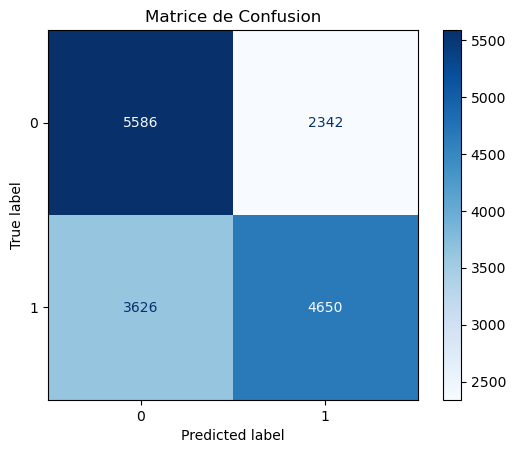

              precision    recall  f1-score   support

           0       0.61      0.70      0.65      7928
           1       0.67      0.56      0.61      8276

    accuracy                           0.63     16204
   macro avg       0.64      0.63      0.63     16204
weighted avg       0.64      0.63      0.63     16204



100%|===================| 16168/16204 [01:56<00:00]        

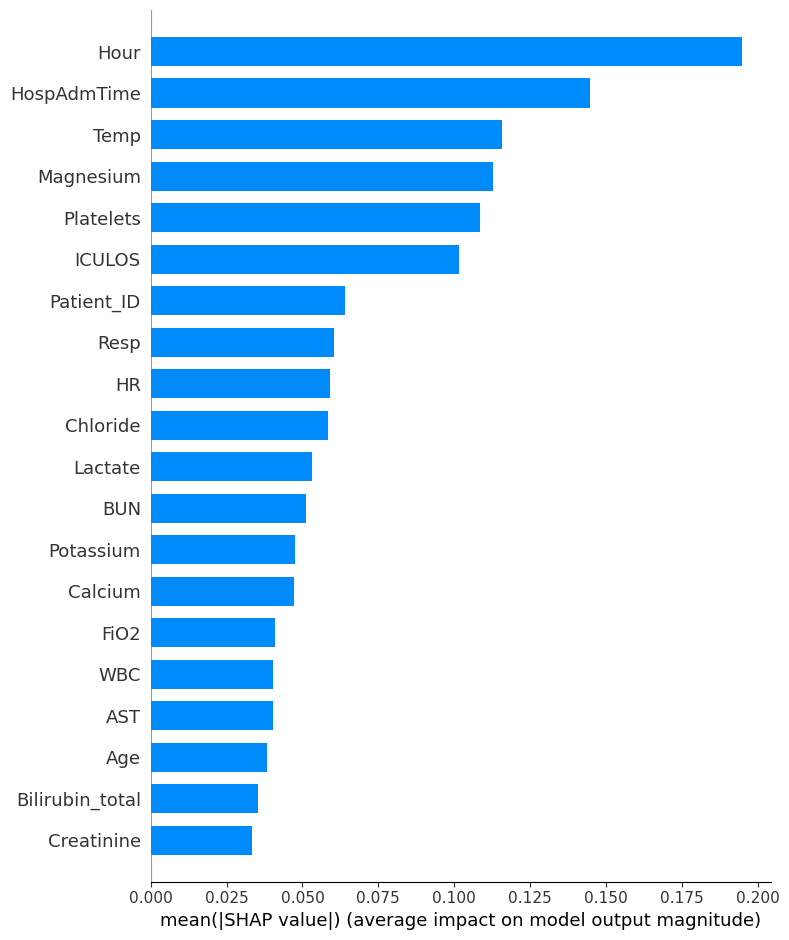

In [105]:
"""
     

"""




def objective_v12(trial, X, y, cv=7):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10), 
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), 
        'gamma': trial.suggest_float('gamma', 0.1, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9)
    }
    clf = create_xgb_classifier(params)
    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    return np.mean(score)



# Calcule des meilleurs hyperparamètres
best_params_v12, study = perform_hyperparameter_optimization(X_train, y_train, objective_v12, n_trials=100)
print("Meilleurs hyperparamètres:", best_params_v12)
study_filename = 'optuna_study_0608_v12.pkl'
save_study(study, study_filename)



# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'xgboost_model_0608_v12.joblib'
xgbc_model_v12 = train_and_save_xgboost_classifier_v2(X_train, y_train, best_params_v12, model_path)

# Prédiction et évaluation
evaluation_report = predict_and_evaluate_v2(xgbc_model_v12, X_test, y_test)
print(evaluation_report)

# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model_v12, X_train, X_test)